# Cupid: Pairs Trading for Fun and Profit
- Rahul Agrawal
- Ivan Petrov
- Younghun Lee
- Tobias Rodriguez del Pozo

---

# <center> Introduction and Table of Contents

This notebook is split into 6 parts:
1. Introduction, Overview of Codebase, Data, and Literature Review
2. Pair Selection
3. Copula Estimation and Signal Generation
4. Spread Construction
6. Portfolio Construction
7. Backtesting and Results

## <center> Overview of Codebase

Given the lack of existing code for mixed copulas, and applications of clustering to pairs trading, virtually all of the libraries we use are writted by us (of course, excluding the canonical data analysis libraries). We could not find existing libraries which implemented mixed copulas to a satisfactory standard, nor any containing particularly useful code for the other tasks in this project.

The codebase is split into four main modules:
- `copulas`: Contains the implementations for the copulas, fitting and optimizing a mixed copula, and kernel-density estimation for distributions. It extends the existing `statsmodels` copulas and maintains the same API.
- `pairs`: Contains the implementaiton for the pair selection process of this project.
- `backtest`: Contains the implementation for signal generation, spread construction/hedging to encapsulate regressions, and backtester, which is used to evaluate the performance of the strategy.
- `analysis`: Modularized plotting functions for analysis used in this notebook and the accompanying pitch deck.

# <center> Data Overview

In this project, we use minute-level data from WRDS to download the constituent stocks of the S&P 500 index. Of course, these change year-over-year, and unfortunately WRDS no longer provides historical members of the S&P. Therefore, we downloaded the members for a given year and have aggregated them into a single file. This file is then used to download the constituent stocks for each year. These are aggregated for a year (since SPX rebalances annually), and then saved to a ~300mb csv file.

We download the stocks from the Trade and Quote (TAQ) database within WRDS. This is done by an SQL query within a seperate python script. Due to the very large size of the data and subsequent computational limitations, as well as the issues with trade or tick-level data, we aggregate the trades into minute-level data. This is done by taking the first price of each minute between 09:30:00 and 16:00:00, and then taking the last instance of these prices. Note that this may introduce some issues caused by incorrect ticks, but we have not found major outliers or problems (for the most part) with this method. Moreover, we also include the volume traded during that minute.

The data is adjusted for stock splits, but not for dividends. The reason for this is that 1. we could not find a reliable way to get dividend data and then join it, as well as propagate it backwards in history, 2. frequent rebalancing, and 3. only trading at most 10 out of 503 tickers, it means that dividends are likely to not have a large impact on our results.

# <center> Assumptions and Limitations

We assume that we can trade at VWAP, and we impose a minimum delay of 1-minute, between signal and exection price. This may or may not be reasonably, given that there are many broker algos that can beat VWAP, but nontheless is a strong assumption. As mentioned before, we also assume that the last price of any given minute is reliable. We fill in missing data via a forward fill, assuming that had we executed during a minute with no trades, we would have executed at the last seen price.

Throughout, we point to further assumptions and limitations where they are relevant.

**NOTE**: Throughout this notebook, we have chosen 3 weeks in March 2022 to focus on, as an example for the full pipeline of our trading strategy. This was chosen at random, and is used for pedagogical purposes only.


# <center> Literature Review

The skeleton of our strategy is inspired by the  2013 paper by Rong Liew and Yuan Wu titled "Pairs trading: A Copula Approach". They implement a related copula-based strategy and demonstrate the potential of generating trading signals from the partial derivatives of copulae compared to classic distance- and cointegration-based approaches. Like us, they confine their research to Archimedean copulae to make use of closed forms and avoid costly numerical approximations.

We improve upon the proposed strategy in the following ways:
- Selecting pairs using ML methods. Liew and Wu derive their results from a single pair of assets that are famously closely related (BKD \& ESC), in fact BKD, Brookdale Senior Living, acquired Emeritus in 2014.
- Using KDE to estimate the marginal distributions. Authors of the paper simply fit parametric distributions (Error and Generalized Logistic for the two tickers above respectively). This holds up poorly out of sample, while KDE appears to fit much better.
While Liew and Wu fit single copulae to characterize the dependence between two assets, we opt for mixed copulae - linear combinations of two copulae. This allows us to exploit the features of both.

With regards to pairs trading in high-frequency data, Kirkestuen (2018) investigates the profitability of pairs trading in the US equity market. The paper mainly used cointegration approach to execute pairs trading strategy, assuming that the co-integrated pairs will have same co-integration over the trading period They backtested high frequency pairs trading strategies using minute-by-minute data from the S&P 500 constituents. Their back-testing setting is two days of formation period and following one day of trading period. In our research, we implemented similar back-test setting as Kirkenstuen (2018) but we extended the formation period to two weeks and trading period to one week.

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
from collections import defaultdict
import re
import matplotlib.gridspec as gridspec
if sys.path[-1] != '../':
    sys.path.append('../')

from analysis.plotting import *
from analysis.performance import perf_summ

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('./data/monthly/prices_Mar_2022.csv', parse_dates=[0], index_col=[0])
data.ffill(inplace=True)
data.isna().sum().sum()
price = data.copy()

In [3]:
start = '2022-03-07'
end = '2022-03-18'
trading_start = '2022-03-21'
trading_end = '2022-03-25'

formation_price = price.loc[start:end]
trading_price = price.loc[end:trading_end]
formation_price.shape

(3910, 493)

***
# <center> Methodology
# 1. Pair Selection
Pairs Trading is one of the most valuable market-neutral strategies used by hedge funds. It is particularly interesting because it overcomes the arduous process of valuing securities by focusing on relative pricing. By buying a relatively undervalued security and selling a relatively overvalued one, a profit can be made upon the pair’s price convergence. However, with the growing availability of data, it became increasingly harder to find rewarding pairs. In this work, we address two problems: (i) how to find profitable pairs while constraining the search space and (ii) how to avoid long decline periods due to prolonged divergent pairs. To manage these difficulties, the application of machine learning and promising statistical techniques are investigated in detail. We propose the integration of an Unsupervised Learning algorithm, OPTICS, to handle problem (i). 

In [4]:
from pairs.selection import PairSelection

## 1.1 Clustering

To decide which algorithm is more appropriate, some problem-specific requisites are first defined:
- No need to specify the number of clusters in advance.
- No need to group all securities.
- Strict assignment that accounts for outliers.
- No assumptions regarding the clusters’ shape.
  
By making the number of clusters data-driven, we introduce as little bias as possible. Furthermore, outliers should not be incorporated in the clusters, and therefore grouping all assets should not be enforced. In addition, the assignment should be strict, otherwise the number of possible pair combinations increases, which is conflicting with the initial goal. Finally, due to the nonexistence of prior information that indicates the clusters should be regularly shaped, the selected algorithm should not assume this.
   
#### DBSCAN  
Taking into consideration the previously described requirements, a density-based clustering algorithm seems an appropriate choice. It forms clusters with arbitrary shapes, and thus no gaussianity assumptions need to be adopted. It is naturally robust to outliers as it does not group every point in the data set. Furthermore, it requires no specification of the number of clusters.
  
The DBSCAN algorithm is the most influential in this category. Briefly, DBSCAN detects clusters of points based on their density. To accomplish that, two parameters need to be defined: $\epsilon$, which specifies how close points should be to each other to be considered “neighbours”, and minPts, the minimum number of points to form a cluster. From these two parameters, in conjugation with some concepts that we omit here, clusters of neighbouring points are formed. Points falling in regions with less than minPts within a circle of radius $\epsilon$ are classified as outliers, hence not affecting the results. Nevertheless, DBSCAN still carries one drawback. The algorithm is appropriate under the assumption that clusters are evenly dense. However, if regions in space have different densities, a fixed $\epsilon$ may be well adapted to one given cluster density, but it might be unrealistic for another.
  
#### OPTICS 
The OPTICS algorithm addresses this problem. OPTICS is based on DBSCAN, with the introduction of some notions that accomplish a varying $\epsilon$ implementation. In this enhanced setting, the investor is only required to specify the parameter minPts, as the algorithm is capable of detecting the most appropriate $\epsilon$ for each cluster. Therefore, we propose using OPTICS not just to account for varying cluster densities but also to facilitate the investor’s task.

In [5]:
ps = PairSelection(formation_price)
ps.create_clusters()

- The graphs below show that the groups created by OPTICS indeed have a lot of similarity in their movements.

sym_root                             
            count                         join
Clusters                                      
0               4           A, GOOG, ROST, WAT
1               4            DTE, ED, LNT, WEC
2               6  DOV, FIS, GPN, IP, NWS, WTW
3               5      ADP, EVRG, MRK, SO, SRE
4               5   AJG, KEYS, MMC, NDAQ, POOL
5               5     IRM, KMI, TSN, WMB, XRAY

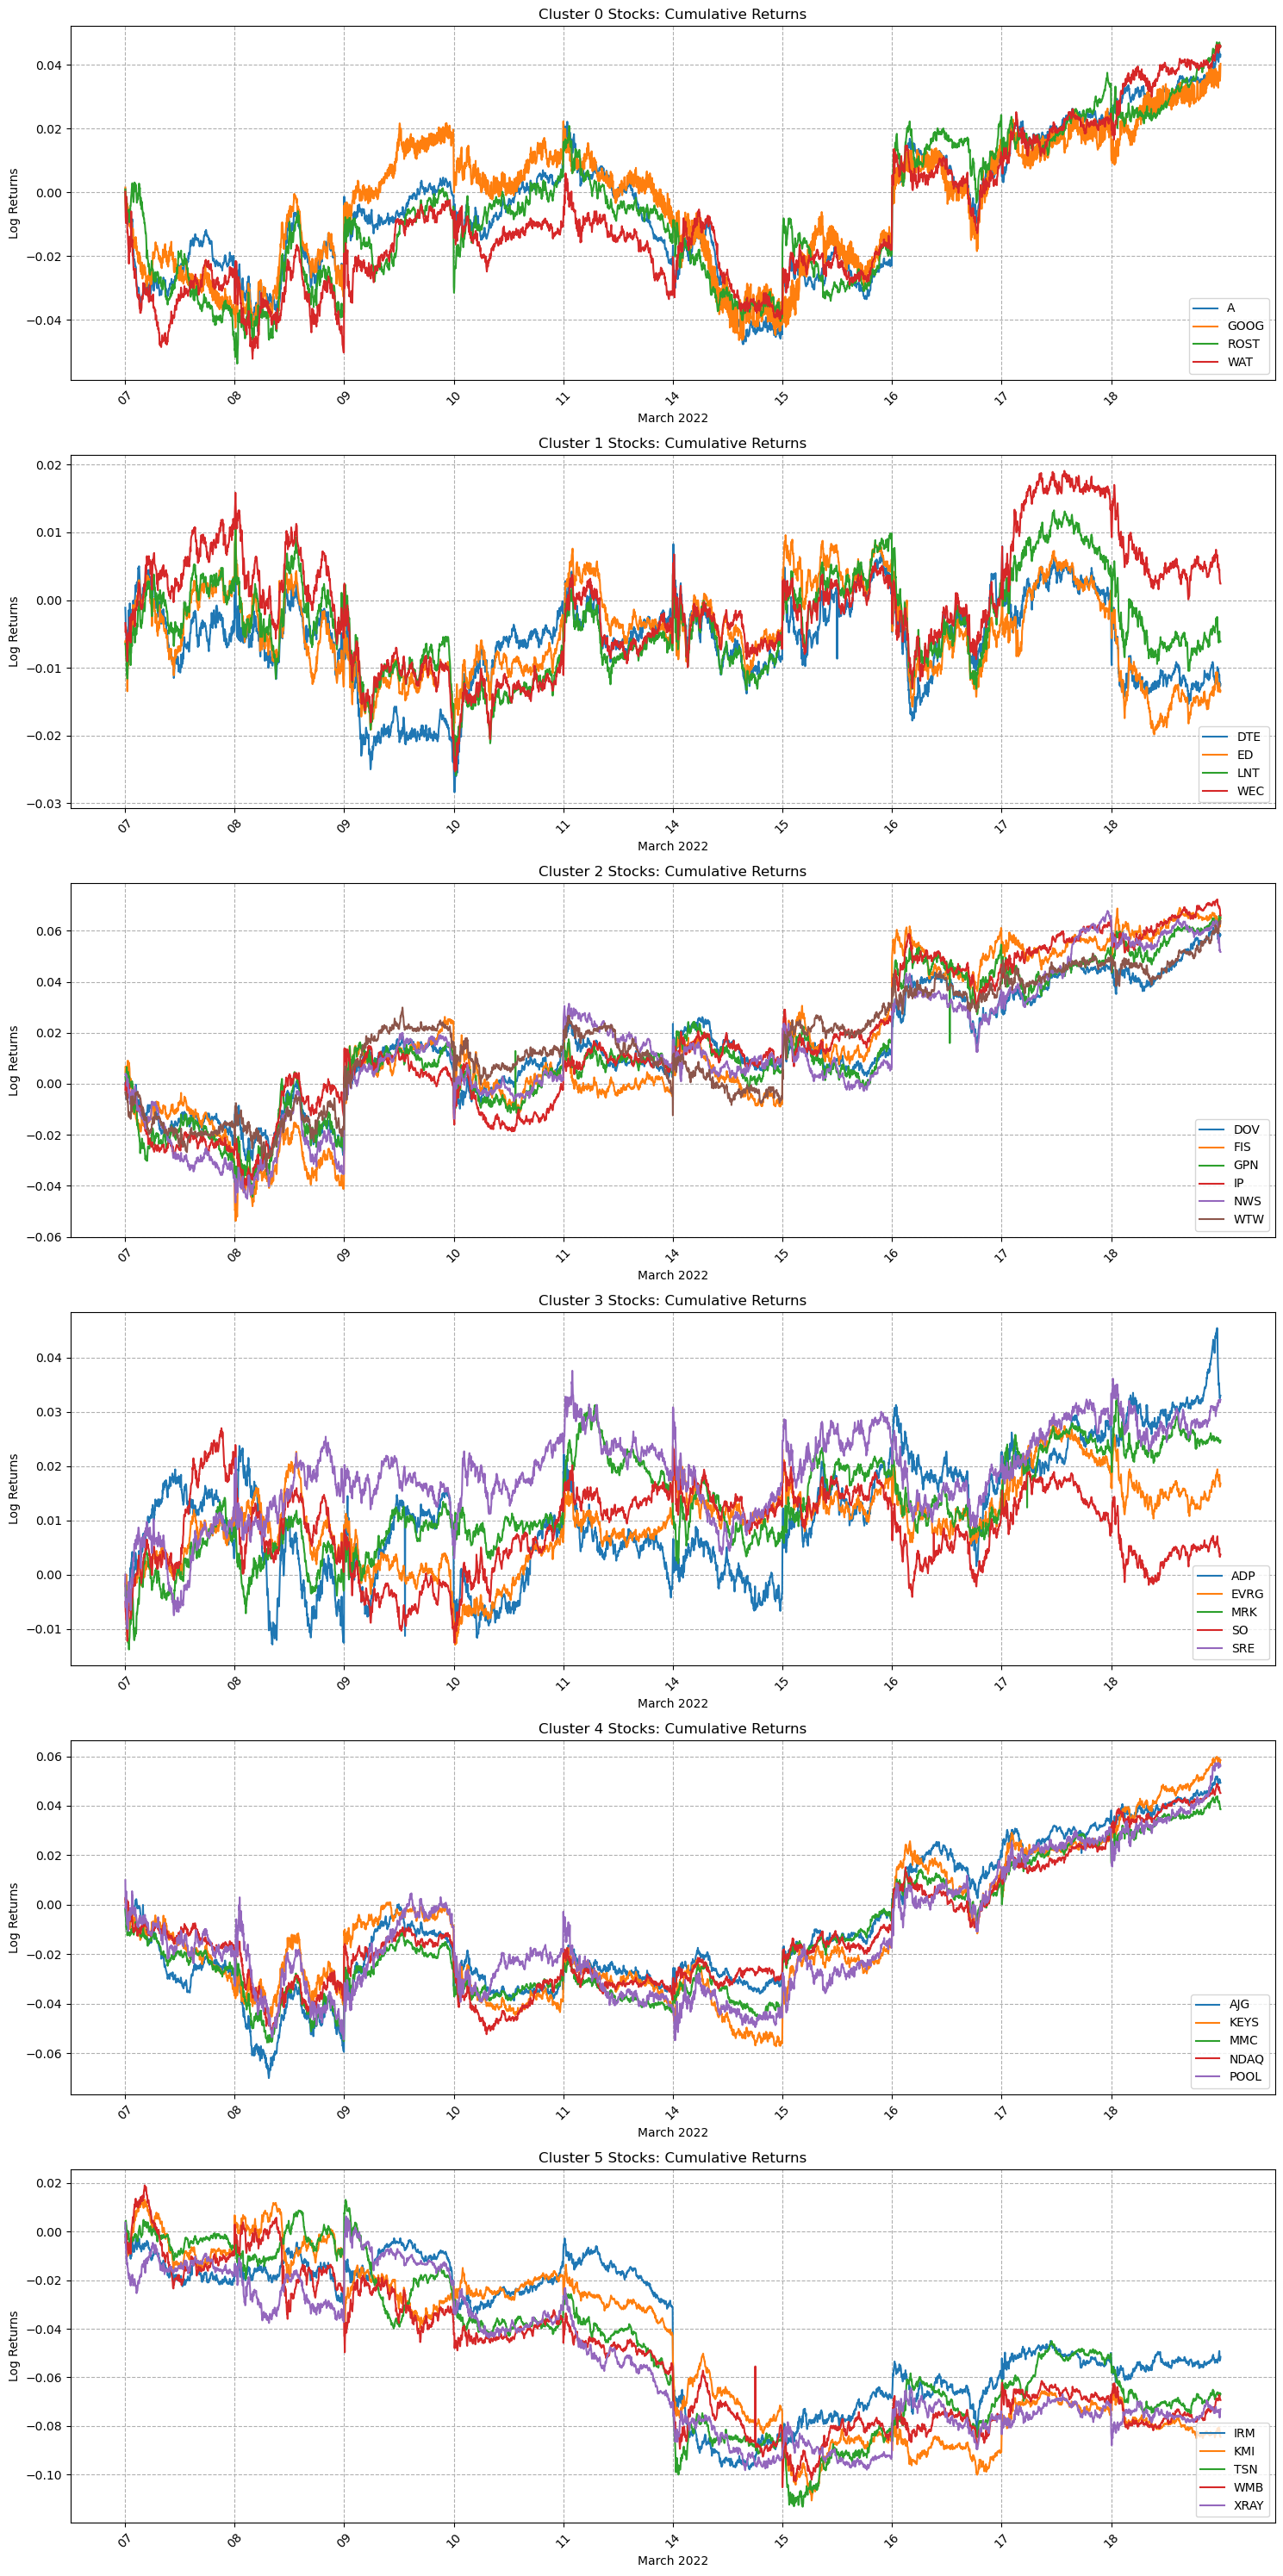

In [60]:
display(ps.groups)
get_group = lambda x: ps.groups.loc[x, ('sym_root', 'join')].split(', ')
number_of_groups = len(ps.groups)

fig, ax = plt.subplots(number_of_groups, 1, figsize=(15,5*number_of_groups))

x_minutes = ps.log_returns.index
x_plot = range(0, len(x_minutes))
x_labels = x_minutes[~x_minutes.strftime("%d").duplicated()]
x_ticks = np.where(np.in1d(x_minutes, x_labels))[0]

for i in ps.groups.index:
    syms_in_group = get_group(i)
    for s in syms_in_group:
        y = ps.log_returns[s]
        ax[i].plot(x_plot, y, label=s)

    ax[i].set_xticks(x_ticks, x_labels.strftime("%d"), rotation=45)

    ax[i].legend(loc=4)
    ax[i].grid(linestyle='--')
    ax[i].set_title(f'Cluster {i} Stocks: Cumulative Returns')
    ax[i].set_ylabel('Log Returns')
    ax[i].set_xlabel('March 2022')

plt.tight_layout()
plt.show()

## 1.2 Top pairs by co-integration
The Engle-Granger test for cointegration is a statistical method used to determine whether two time series are cointegrated, meaning that they share a common long-term trend despite short-term fluctuations.  
  
In pairs trading, the Engle-Granger test can be used to identify pairs of stocks that are likely to move together over time. To apply the test, one first selects a set of potential pairs based on some relevant criteria (such as belonging to the same industry or having similar market capitalizations), here, we use clustering technique OPTICS.
  
Next, the historical price data for each stock in the pair is analyzed to determine whether they are cointegrated using the Engle-Granger test. If they are found to be cointegrated, this suggests that there is a long-term relationship between the two stocks that can be exploited for pairs trading.

We rank the pairs using the p-value.

In [7]:
ps.test_coint()
ps.coint_result.head(30)

sym1  sym2 cluster         p         t        1%        5%       10%
0    DOV   GPN       2  0.000033 -5.369208 -3.899244 -3.337694 -3.045535
1    MRK   SRE       3  0.000447 -4.758386 -3.899244 -3.337694 -3.045535
2    GPN    IP       2  0.000885 -4.584838 -3.899244 -3.337694 -3.045535
3      A  ROST       0  0.001346 -4.474912 -3.899244 -3.337694 -3.045535
4    WMB  XRAY       5  0.003098 -4.246549 -3.899244 -3.337694 -3.045535
5    TSN   WMB       5  0.007187  -3.99974 -3.899244 -3.337694 -3.045535
6   ROST   WAT       0  0.007726 -3.977653 -3.899244 -3.337694 -3.045535
7    GPN   WTW       2  0.010375 -3.885845 -3.899244 -3.337694 -3.045535
8    DOV   NWS       2  0.011094 -3.864576 -3.899244 -3.337694 -3.045535
9    DOV   FIS       2  0.017086 -3.723564 -3.899244 -3.337694 -3.045535
10   FIS   WTW       2   0.01787 -3.708495 -3.899244 -3.337694 -3.045535
11   GPN   NWS       2  0.028222 -3.549881 -3.899244 -3.337694 -3.045535
12     A  GOOG       0  0.032181 -3.502425 -3.899244 -3.337694 -3.045535
13   FIS    IP       2  0.035733 -3.463899 -3.899244 -3.337694 -3.045535
14   DOV    IP       2  0.040086 -3.420863 -3.899244 -3.337694 -3.045535
15   MMC  NDAQ       4   0.04054 -3.416598 -3.899244 -3.337694 -3.045535
16   DOV   WTW       2  0.045838 -3.369629 -3.899244 -3.337694 -3.045535
17  KEYS  POOL       4  0.046225 -3.366374 -3.899244 -3.337694 -3.045535
18   MMC  POOL       4  0.048919 -3.344343 -3.899244 -3.337694 -3.045535
19   KMI  XRAY       5  0.054849 -3.299171 -3.899244 -3.337694 -3.045535
20  GOOG  ROST       0  0.058618 -3.272493 -3.899244 -3.337694 -3.045535
21   DTE    ED       1  0.060745 -3.258045 -3.899244 -3.337694 -3.045535
22   NWS   WTW       2  0.072122 -3.187038 -3.899244 -3.337694 -3.045535
23   LNT   WEC       1  0.074895 -3.171102 -3.899244 -3.337694 -3.045535
24   ADP   MRK       3  0.076339 -3.162983 -3.899244 -3.337694 -3.045535
25   AJG   MMC       4  0.094282 -3.070978 -3.899244 -3.337694 -3.045535
26   AJG  POOL       4  0.097015 -3.058179 -3.899244 -3.337694 -3.045535
27   FIS   GPN       2   0.10029 -3.043203 -3.899244 -3.337694 -3.045535
28   TSN  XRAY       5  0.110319 -2.999522 -3.899244 -3.337694 -3.045535
29  EVRG   MRK       3  0.113033 -2.988218 -3.899244 -3.337694 -3.045535

## 1.3 Top pair selection
The top pair selection is done by making sure that the symbol in any already selected pair is not repeated so that we do not end up repeating exposure in certain stocks.  

Secondly, we also limit ourselves to pairs that have a p-value <= 0.05. This ensures that we are trading pairs which we are confident about being cointegrated.

This does result in weeks where we may end up with less than desired or no pairs to trade.  
  
Here, you can see the pairs we end up selecting are not in fact the top 'n' pairs of the above result.

In [8]:
# pairs_selected = ps.get_pairs()
pairs_selected = [('SRE', 'MRK'),
                    ('BXP', 'AEP'),
                    ('CB', 'DGX'),
                    ('PEP', 'AWK'),
                    ('KMB', 'K')]
for i, (sym1, sym2) in enumerate(pairs_selected):
    print(f"{f'Pair {i+1}':7s}  {sym1:5s} {sym2}")

Pair 1   SRE   MRK
Pair 2   BXP   AEP
Pair 3   CB    DGX
Pair 4   PEP   AWK
Pair 5   KMB   K


### 1.4 Type-1 Error

This method does have the potential to introduce type-1 error into the pairs, since we are doing an exhaustive search of each cluster. However, we believe this is mitigated by the fact that we are clustering the pairs in the first place, rather than attempting to search the entire pair universe exhaustively.

We also found that we had a non-trivial number of weeks where we only traded 2 or 3 pairs, and occasionally 0, indicating that the likelihood of consistently having all traded pairs be artefacts of type-1 error is somewhat low.

# 2. Estimating Distribution: Copula Strategy

Having selected the related pairs, we turn our attention to extracting their dependence structures. 

Here, we will estimate distributions of the stocks in the pairs. After estimating distribution, we will use the estimated distribution to combine into form of joint distribution, using a method called copula.

We could not find an existing library that could implement both KDE distributions and optimize mixed copulas, so we had to implement our own.

In [9]:
from copulas.fitting import CopulaPairs, CopulaSelection
from copulas.distributions import KDEDist
import scipy.stats as stats

In [10]:
i, j = 0, 0

rolling_n = 200
pair = pairs_selected[i]
ticker = pairs_selected[i][j]

#### **Limitation of Linear Pairs Trading Strategy**

 Linear trading strategies assume that there exists a common trend with zero draft assumption. When the pair is cointegrated, that means that the pair share a common trend, which is represented by the linear combination of themselves. Linear strategies have two strong assumptions about the trend:
1. That the common trend is stationary
2. That the common trend will be the same in the trading period as in the formation period.

As such they use the common trend as a spread, using the coefficient of the linear combination as the hedge ratio (the ratio of the long versus short position).

However, as demonstrated below, the spread is not stationary as the drift is changing. For this demonstration, we calculated beta by using the linear regression of the two stocks. This is because linear regression with constant term analyze the relationship between two demeaned stocks so that the beta should make the spread have a constant mean. Also, under the assumption that the pairs are cointegrated and they have a stationary common trend, there will be a ratio that makes the spread with constant mean, and this ratio should be the same as the beta.

Beta is calculated from the formation period, and the graph is plotted from the formation period to the trading period.


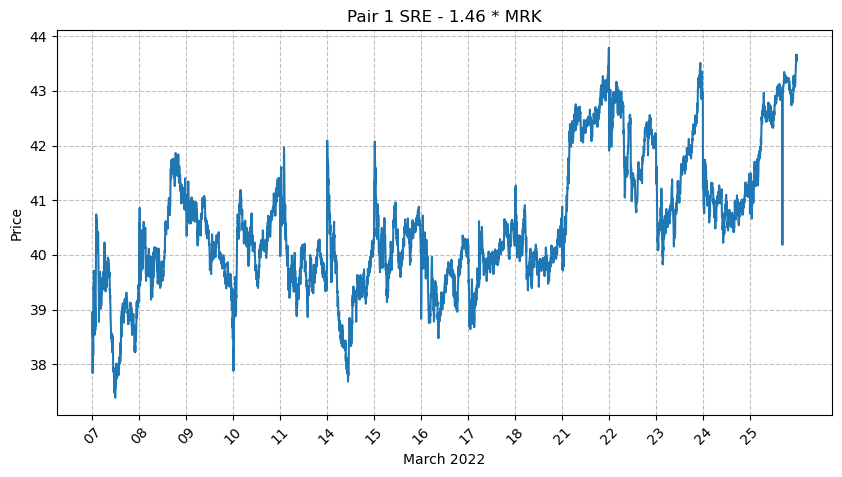

In [11]:
plot_linear(formation_price, price, pair, start, trading_end, 0)

This failure to account for the emergence of a potential trend component further means that a linear pairs trading strategy may have tail risks. We argue this is because if there are outliers or extreme events in the trading period, and the spread stops being stationary, then we are suddenly generating trading signals based off of nonsense, and may end up in a position where we take a large position that bets on convergence, when in fact the spread is diverging.

## 2.1 Strategy Introduction
In the formation period, 
   1. Estimate the distribution of each stock in the pair.
   2. Combine the distributions into a joint distribution using a copula.

In the trading period,
   1. Calculate values of conditional probabilities, which indicates the possibility of the occurance of `stock X`'s current price level, given the current price level of `stock Y`. 
   2. Let's denote the two probabilities as below:

\begin{align*}
   P(X \leq x | Y = y) = \frac{\partial}{\partial y}C(p_x, p_y), \\
   P(Y \leq y | X = x)= \frac{\partial}{\partial x}C(p_x, p_y)
\end{align*}

   3. Based on the two conditional probabilties, we decide the entry time of the pair.
   4. A position is entered when one of the conditional probability values is above the upper bound, whereas the other is below the lower bound.
   5. We exit position once the condtitional probability across the exit threshold.

This allows us to detect abnormally large return values (high probability) and low return values (low probability) and trade accordingly. Note that this says nothing about the absolute price levels. Since a copula only characterizes the relationship between the two assets, we can only detect relative movements in price. <br>

For example, a probability of 0.95 tells us that, for the current price of one leg of the spread, the other leg's price is in the 95th percentile of all possible values. Our philosophy is that relatively extreme values like this do not persist. We therefore short sell the relatively overpriced leg and purchase the underpriced leg. Since our approach does not tell us which of the assets is priced abnormally, we cannot expect to make a profit on both legs of the spread. However, the deviation from the norm in their relative prices allows us to conclude that at least one of the legs' prices will make a move to correct the conditional probabilies back to the equilibrium level of 0.5.

## 2.2 Standardizing the price

Pairs trading strategy takes long position on relatively cheap stock and short position on relatively expensive stock. This means that the level of the price is important to capture the trading opportunities. To compare the level of both stocks, we need to standardize the price of each stock. We introduce the following formula to standardize the price of each stock:

$$ z_{i,t} = log\left(\frac{price_{i,t}}{moving\ average(n)_{i,t-1}}\right) $$

As well know the price follows stochastic process with exponential form. This is why we are taking log of the price. At the same time, we divide the price by moving average beacuse the actual mean of the price level may change over time. Even if the actual mean is constantly maintained over time, we are analyzing high frequency timeframe, so that the price may fluctuate around the different mean from the actual mean for a long time. This is why we are introducing moving average to standardize the price.

Below is the comparison of two standardizing method. 

Left plot is using $$log\left(\frac{price}{moving\ average(n)}\right)$$ while right is $$log\left(\frac{price}{price\ at\ 0}\right)$$ We can see that the left one is more centered than the right plot. This matters because we are going to see whether current level of stock A is higher than stock B through joint distribution between two stocks.

If we are using the second standardization method, there may be the high possibility that the distribution may return mal the level of the stock is higher in the trading period than the formation period, which will return poor and volatile result from the joint distribution.

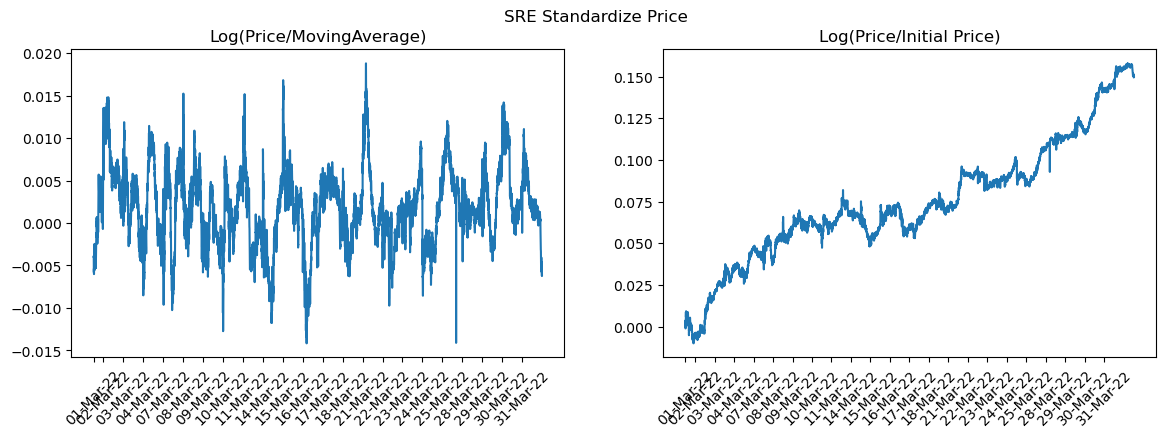

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
std_logma = standardize_logma(price[ticker], rolling_n).rename('Log(Price/MA)')
std_log = standardize_log(price[ticker]).rename('Log(Price)')

x_minutes = std_logma.index
x_plot = range(0, len(x_minutes))
x_labels = x_minutes[~x_minutes.strftime("%d-%b-%y").duplicated()]
x_ticks = np.where(np.in1d(x_minutes, x_labels))[0]

ax[0].plot(std_logma.values)
ax[0].set_xticks(x_ticks, x_labels.strftime("%d-%b-%y"), rotation=45)
ax[0].set_title(f"Log(Price/MovingAverage)")

ax[1].plot(std_log.values)
ax[1].set_xticks(x_ticks, x_labels.strftime("%d-%b-%y"), rotation=45)
ax[1].set_title(f"Log(Price/Initial Price)")

fig.suptitle(f"{ticker} Standardize Price")
plt.show()

Our implementation of standardizing shows $I(0)$ process and would be capable to compare current 

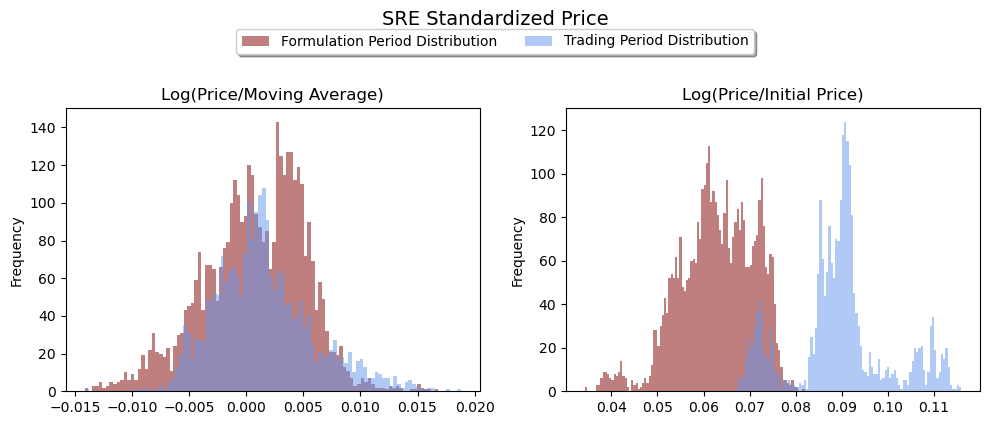

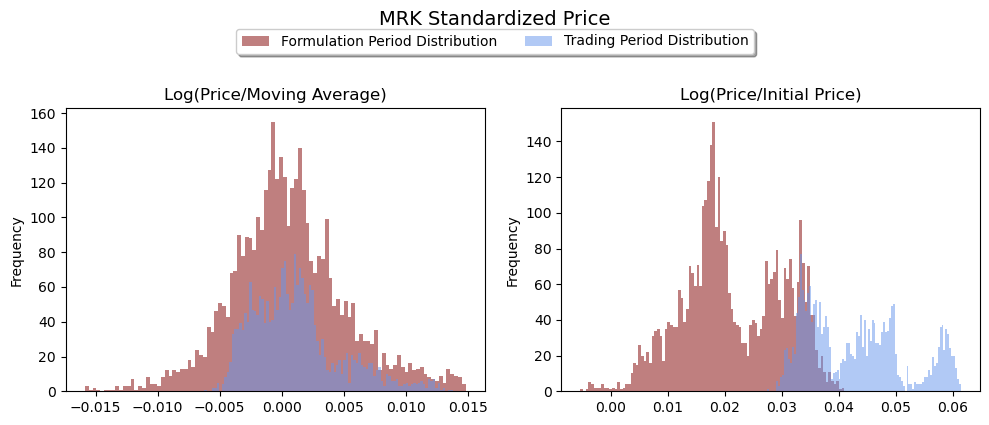

In [13]:
fig2 = std_comparison(price[pair[0]], start, end, trading_end, rolling_n)
fig2.suptitle(f"{ticker} Standardized Price", y = 1.05, fontsize = 14)

display(fig2)
fig3 = std_comparison(price[pair[1]], start, end, trading_end, rolling_n)
fig3.suptitle(f"{pair[1]} Standardized Price", y = 1.05, fontsize = 14)
display(fig3)

## 2.3 Estimating marginal distribution: Kernel Density Estimation (KDE)

Kernel density estimation is a non-parametric way to estimate the probability density function of a random variable. It is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample.
Strength of using KDE is that it is adaptive to the form of the empirical data. It is hard to assume the form of parametric distribution, since the data often have skeweness and kurtosis.

### 2.3.1 KDE formula

Let $(x_1,x_2,...,x_n)$ be an independent and identically distributed sample from a given univariate distribution, then kde estimates the shape of the distribution $f$ towards pre-specified kernel $K$. The kernel density estimator is formulated below.
\begin{align*}
    \hat{f}_h(x) = \frac{1}{n}\sum_{i=1}^{n}K_h(x-x_i) = \frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-x_i}{h}\right)
\end{align*}
In the equation, parameter $h$, known as bandwidth, affects how smooth the resulting curve is. In our model, we used Scott’s method that $h = n^{-\frac{1}{5}}$ where $n$ is the number of data points. With this bandwidth, scaled kernel $K_h$ is defined as follows:
\begin{align*}
    K_h(x) = \frac{1}{h}K\left(\frac{x}{h}\right)
\end{align*}
Here, we used a Gaussian kernel, which has the form:
\begin{align*}
    K(x;h) \propto e^{-\frac{x^2}{2h^2}}
\end{align*}

### 2.3.2 Experiment with sample data

The plot below is the KDE and Normal distribution comparision within the two weeks of formation period. 

Let's first look at the histogram and normal distribution plots. It is very salient that the data is right skewed in the sample and have heavy tail for the extreme values. Also the kurtosis is high, which means that more data are concentrated around the mean. If we are using Normal distribution to estimate this sample, we will be overestimate the probilities of mediocre upside/downside movement (values around $0.005$ or $-0.005$) and underestimate the extreme values around $0.01$ or $-0.01$. This will result in the poor performance of the strategy by not capturing the extreme movements, and over-capturing mediocre movements.

However, using KDE method, the estimated distribution looks more feasible to the actual data. The KDE is able to capture the extreme values and the heavy tail.


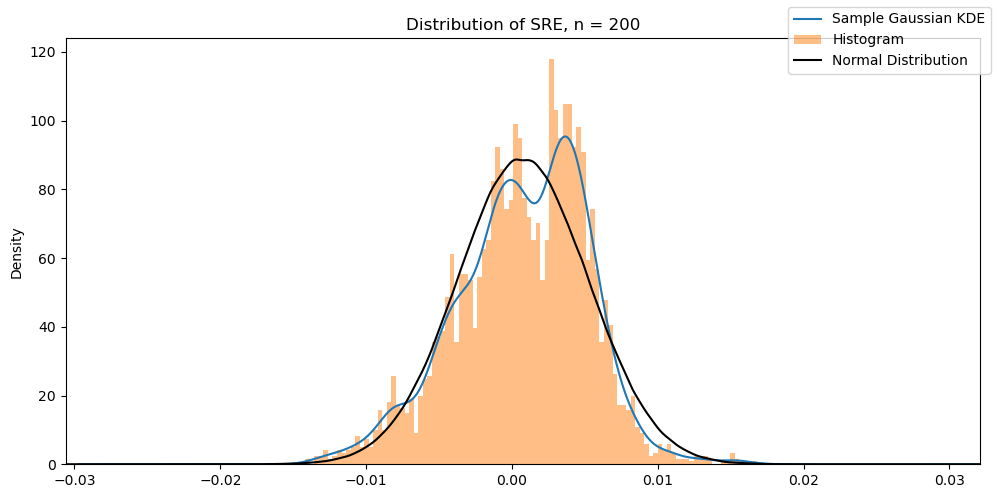

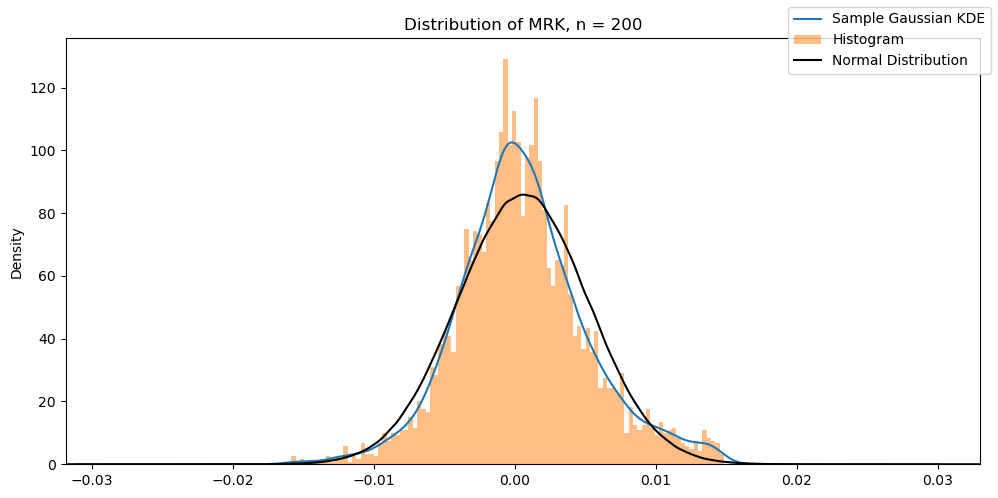

In [14]:
a1 = get_dist(price, pair[0], rolling_n, start, end, standardize= standardize_logma)
display(a1)
a2 = get_dist(price, pair[1], rolling_n, start, end, standardize= standardize_logma)
display(a2)

## 2.4 Estimating joint distribution: Copula

### 2.4.1 Copula

Let $X$ and $Y$, in our case, are standardized prices of two legs of the pair. Also, assume $F(X)$ and $G(X)$ are marginal distributions of $X$ and $Y$, respectively. Then, we fit the Copula $C$ as:

\begin{align*}
C(p_x,p_y) &= \mathbb{P}(F(X) \leq p_x,\ G(Y) \leq p_y)\\
&= \mathbb{P}(X \leq x, Y \leq y)\\
\end{align*}

where $p_x = F(X=x)$ and $p_y = G(Y=y)$. 

To generate signals, we use the fact that:
\begin{align*}
\mathbb{P}(X \leq x | Y = y) = \frac{\partial}{\partial y}C(p_x, p_y), \\
\mathbb{P}(Y \leq y | X = x)= \frac{\partial}{\partial x}C(p_x, p_y)
\end{align*}
	

In [15]:
sample_in = standardize_logma(price[list(pair)], rolling_n).loc[start:end]
sample_out = standardize_logma(price[list(pair)], rolling_n).loc[end:trading_end]
copula_fitter = CopulaSelection(sample_in, pair)
copula_fitter.candidate_copulas

['gumbel', 'clayton', 'independence', 'gaussian']

### 2.4.2 Scatter plot of sample data (Empirical distribution)

Below is the scatter plot of the sample data. Based on the distribution we need to compute conditional probabilities.

However, using empirical distribution is not feasible to compute conditional probabilities. This is because the empirical distribution is not smooth and it is hard to compute the probability when there are only few data points available in in-sample around the current value.

For this reason, we are using **Copula** to estimate the joint distribution. Copula is a multivariate generalization of the univariate cumulative distribution function. It is a function that maps a vector of marginal cumulative distribution functions to a vector of joint cumulative distribution functions.

From the second plot (trading period), the conditional probability of the point $(-0.01, -0.01)$ may not be able to be computed from the formation period. This is because, when IBM's value is around $-0.01$, there are only few data points in the first scatter plot.

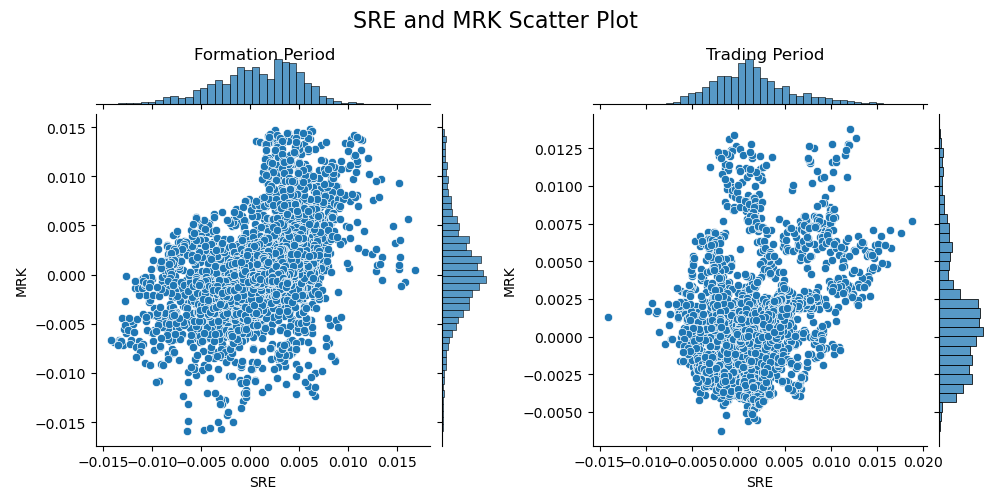

In [16]:
sample_in_scatter = sns.jointplot(x=sample_in.iloc[:, 0], y=sample_in.iloc[:, 1], kind="scatter", height=4)
sample_out_scatter = sns.jointplot(x=sample_out.iloc[:, 0], y=sample_out.iloc[:, 1], kind="scatter", height=4)

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(10,5))
mg0 = SeabornFig2Grid(sample_in_scatter, fig, gs[0])
fig.text(0.27, 0.9, 'Formation Period', ha = 'center', fontsize=12)
mg1 = SeabornFig2Grid(sample_out_scatter, fig, gs[1])
fig.text(0.77, 0.9, 'Trading Period', ha = 'center', fontsize=12)
fig.suptitle(f"{pair[0]} and {pair[1]} Scatter Plot", fontsize=16, y = 1)
fig.tight_layout()
plt.show()

### 2.4.3 Archimedean Copula

Following the estimation, we fit the Gumbel, Clayton, Normal, and Independence copulas. We work with Archimedean copulas because they admit closed forms and therefore do not require computationally expensive numerical methods. We consider the Gumbel and Clayton copulas to be of particular interest as they place more emphasis on the tails.

#### Properties

**Gumbel**
- Allows variable level of upper tail dependence.
- Asymmetric, more weight on the right tail. This is evident from the figure above as points cluster more densely in the upper-right corner.

**Clayton**
- Allows variable level of lower tail dependence.
- Asymmetric, more weight on the left tail. Similar graphical interpretation as the Gumbel copula.

**Gaussian**
- Assume Bivariate Normal distribution.

**Independence**
- Assume that the two variables are independent.

Note, all the joint distribution generated from the copula have same marginal distirbution for each of the stock.

Below scatter plot shows 5000 randomly generated samples from each copula. 

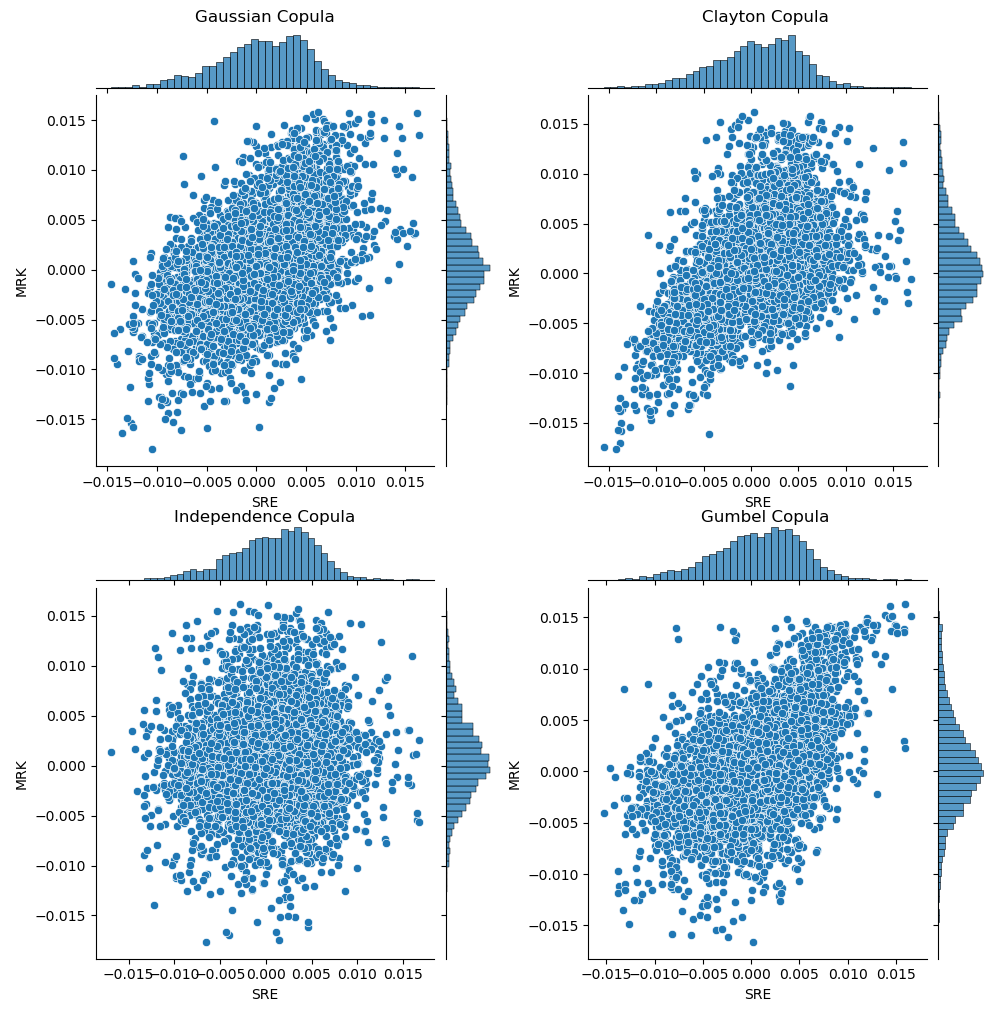

In [17]:
fig_gaussian = plot_copula(copula_fitter, pair, 'gaussian')
fig_clayton = plot_copula(copula_fitter, pair, 'clayton')
fig_ind = plot_copula(copula_fitter, pair, 'independence')
fig_gumbel = plot_copula(copula_fitter, pair, 'gumbel')

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,10))

mg0 = SeabornFig2Grid(fig_gaussian, fig, gs[0])
fig.text(0.27, 1, 'Gaussian Copula', ha = 'center', fontsize=12)
mg1 = SeabornFig2Grid(fig_clayton, fig, gs[1])
fig.text(0.77, 1, 'Clayton Copula', ha = 'center', fontsize=12)
mg2 = SeabornFig2Grid(fig_ind, fig, gs[2])
fig.text(0.27, 0.5, 'Independence Copula', ha = 'center', fontsize=12)
mg3 = SeabornFig2Grid(fig_gumbel, fig, gs[3])
fig.text(0.77, 0.5, 'Gumbel Copula', ha = 'center', fontsize=12)
fig.tight_layout()
plt.show()

### 2.4.4 Selecting Copula

To evaluate which copula fits well for the specific pair that we are going to trade, we use the following criterias:
- AIC (Akaike Information Criterion): Minimize likelihood ratio. This tries to find unknown model that has high dimensional reality.
- BIC (Bayesian Information Criteria): Assumes the model is true.
- SIC
- HQIC

These criterias are based on the likelihood function of the copula, but differ by their assumptions on the distribution of the error term.

The copula with the lowest mean value over the criterias is chosen as the best fit for the pair.

In [18]:
single_res = copula_fitter.evaluate_copula()
single_res['Mean Criteria'] = single_res.mean(1)
single_res['Ranking'] = single_res['AIC'].rank(ascending=True).astype(int)
single_res

AIC           SIC          HQIC           BIC  \
gumbel       -63611.706652 -63605.435359 -63609.481070 -63597.164066   
clayton      -63023.912575 -63017.641282 -63021.686993 -63009.369989   
independence -62640.916441 -62634.645149 -62638.690860 -62626.373856   
gaussian     -63622.919821 -63616.648529 -63620.694240 -63608.377236   

              Mean Criteria  Ranking  
gumbel        -63605.946787        2  
clayton       -63018.152710        3  
independence  -62635.156576        4  
gaussian      -63617.159956        1

### 2.4.5 Mixture Copula

To further improve the performance of the strategy, we are using mixed copula. Mxture copula combines the traits of the copula so that it is more adaptive to the pair that we would like to analyze. It is simply represented as the linear combination of two or more copula and is used to determine the multivariate spatial dependence across bins as a weighted linear combination of copula. In our trading strategy, we consider the two combination of the copula.

\begin{align*}
    C_{mix}(p_x, p_y) = \alpha C_1(p_x, p_y) + (1-\alpha)C_2(p_x, p_y)
\end{align*}

The conditional probabilities using mixture copula copula is straightforward as the density is also calculated as linear combination of two conditional probabilities.

\begin{align*}
    &\mathbb{P}_{mix}(X \leq x | Y = y) \\
    &= \frac{\partial}{\partial y}C_{mix}(p_x, p_y)\\
    &= \frac{\partial}{\partial y}[\alpha C_1(p_x, p_y) + (1-\alpha)C_2(p_x, p_y)]\\
    &= \frac{\partial}{\partial y}\alpha C_1(p_x, p_y) + (1-\alpha )\frac{\partial}{\partial y}(C_2(p_x, p_y))\\
    &= \alpha \mathbb{P}_{C_1}(X \leq x | Y = y)+ (1-\alpha)\mathbb{P}_{C_2}(X \leq x | Y = y)
\end{align*}

As same with single copula case, we use the same criterias to select the best fit mixture copula. The table below shows the values of criterias for each copula as well as alpha, which is the ratio of linear combination of two copula. This alpha is set as the mixture copula minimize the log-likelihood function.

We assume that the mixture copula will be meaningful as right/left tail of the distribution is important. So we also assume that the gumbel/clayton copula will best fit the formation period and works well in the trading period. As can be seen in the below table, gumbel/clayton shows the best performance in the formation period. This is similar on the other pairs as well.

Due to the computational complexity of optimizing alpha for every formation period, we choosed to focus on gumbel, clayton and gumbel/clayton mixture copula for the implementation on the trading strategy.

In [19]:
mixture_res = copula_fitter.evaluate_mixed_copula()
mixture_res['Mean Criteria'] = mixture_res.drop('alpha', axis=1).mean(1)
mixture_res['Ranking'] = mixture_res['AIC'].rank(ascending=True).astype(int)
mixture_res

AIC           SIC          HQIC           BIC  \
gumbel_clayton        -63658.768595 -63652.497303 -63656.543014 -63644.226010   
gumbel_independence   -63626.468070 -63620.196778 -63624.242489 -63611.925485   
gumbel_gaussian       -63671.150181 -63664.878888 -63668.924599 -63656.607595   
clayton_independence  -63290.111119 -63283.839826 -63287.885537 -63275.568533   
clayton_gaussian      -63615.184977 -63608.913684 -63612.959396 -63600.642392   
independence_gaussian -63645.184101 -63638.912809 -63642.958520 -63630.641516   

                          alpha  Mean Criteria  Ranking  
gumbel_clayton         0.799141  -63653.008730        2  
gumbel_independence    0.931890  -63620.708205        4  
gumbel_gaussian        0.483978  -63665.390316        1  
clayton_independence   0.716028  -63284.351254        6  
clayton_gaussian       0.055728  -63609.425112        5  
independence_gaussian  0.056837  -63639.424236        3

Based on the criteria above, we select gumbel-clayton mixeture copula as final mdoel for the trading strategy. $\alpha$ is set to 0.885.

Although it is more close to clayton copula, the plot below have more variation in the left tail, compared to single clayton copula above. Also, this seems to be more adaptive to the formation data, comparing to the scatter plot of 2.4.2

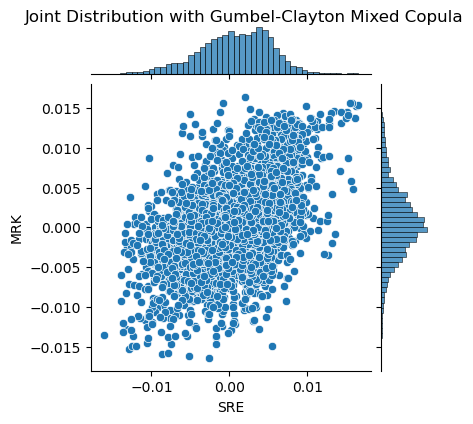

In [20]:
gumbel_clayton = copula_fitter.fit_copula('gumbel',copula_type2 = 'clayton', alpha = 0.885)
fig = plot_joint_dist(gumbel_clayton, pair, 'Gumbel-Clayton Mixed')
display(fig.fig)

## 2.5 Signal Generation

Having constructed tradeable spreads, we now apply the probabilities given by our copula to generate signals. We use a simple heuristic, whereby if the probability is greater than 0.85, 0.9, or 0.95, we short 1,2, or 3 risk-units of the spread, respectively. If the probability is less than 0.15, 0.1, or 0.05, we go long 1,2, or 3 risk-units of the spread, respectively. We also exit trades at 0.8, and 0.2. These numbers are chosen after some trial-and-error, since we found that decreasing these probabilities introduced too many trades. We tried running an optimizer on the in-sample data to find the optimal thresholds, but this virtually always overfit, and converged on nonsensical thresholds.

We now focus on only the top pair, and show how we optimize a portfolio of multiple pairs later in this notebook.

In [21]:
# Signal generation
from backtest.signal_ import SignalGeneration
signal_object = SignalGeneration(price, [pair], start, end, trading_end, copula_type="clayton")
sig1, sig2 = signal_object.calc_signals(single = False)

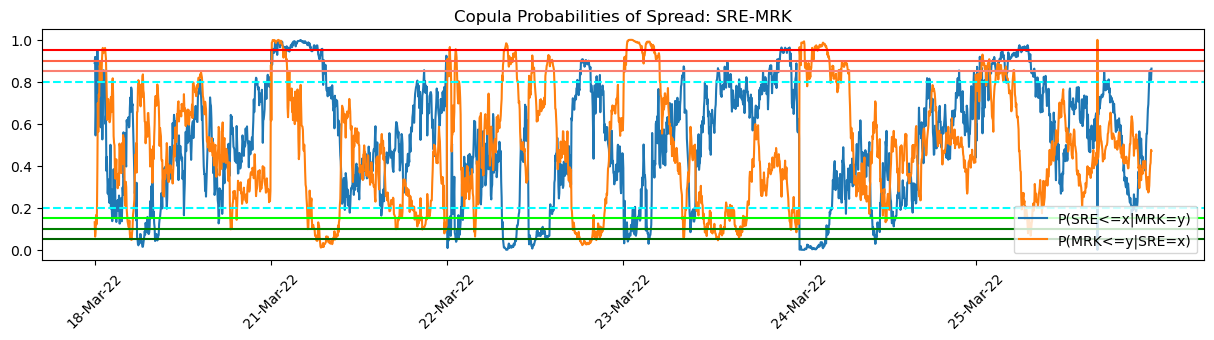

In [22]:
plot_signal(sig1, sig2, trading_price, pair)

# 3. Spread Construction

Now that we've identified pairs, and modeled their dependence, we need to construct an actually tradeable spread. This is where difficulties arise, because a copula makes no assumptions about the ratio of one leg of the spread to other, it merely relates their relative movements. That is, our copulas don't tell us what ratio of the pairs to trade, only when to trade them.

The simplist approach is to simply match notionals. However, this is not necessarily feasible, since firstly, this requires continual rebalancing of the positions, incurring large trading costs. Secondly, it is not always possible to match the notionals, due to execution delays or other factors. Therefore, we select a fixed ratio for the trading period.

We choose to regress the pair using a RANSAC (RANdom SAmple Consensus) Linear Regression. The reason for this is that we have to use a robust regression technique, because including outliers in our spread construction poses a serious problem: since the goal of our strategy is to trade on dislocations between the relative prices, why would we want to include outliers (ie. potentially profitable trades) in our spread construction?

Doing so may lead us to selecting an incorrect ratio to trade, reducing (or entirely eliminating) our profits. The goal of this spread construction is to estimate the "baseline" ratio of the assets. The reason to use a RANSAC model is because it was specifically designed to be robust to outliers and noise, of which our time series, being financial data, has a lot of. Moreover, its iterative approach, whereby it continually refits the model on different samples of the data, and converges on the outlier-free best fit, means that we can be (somewhat) confident that we are, in-fact, estimating the "normal" ratio of the assets.

RANSAC follows the following steps to come to a "consensus" of what the inliers are:
1. Randomly select a subset of the data, as the "possible inliers".
2. Fit a model to the possible inliers.
3. Fit the model to the entire dataset, and determine the inliers. The data points that fit the estimated model well are considered inliers.
4. Repeat steps 1-3 until we have suffient inliers (the consensus set).

We also experimented with a Tukey regression, however, this comes with the disadvantage of having to specify a "threshold" for what is considered an outlier, and it also not iterative. Since these regressions may vary quite drastically from pair to pair, we decided to use RANSAC, which does not require this.

### Limitations

With that being said, there are some risks to this. The primary one is that the out-of-sample spread using our estimated beta, may not be stationary. This poses quite a large problem are mentioned before, but is fortunately mitigated by aforementioned copula methods. The reason for this is that since we're modeling a dependence structure, we can have drift, and still trade (somewhat) profitably. Though, of course, this is not ideal. Another problem is that we're introducing linearity into an explicitly non-linear model. Fortunately, the RANSACRegression in sklearn can be passed an "estimator" argument, so we could conceivably introduce additional complexity, but that is left for future work.

Below we show an estimated normal OLS, compared with a RANSAC regression for our top 7 pairs.

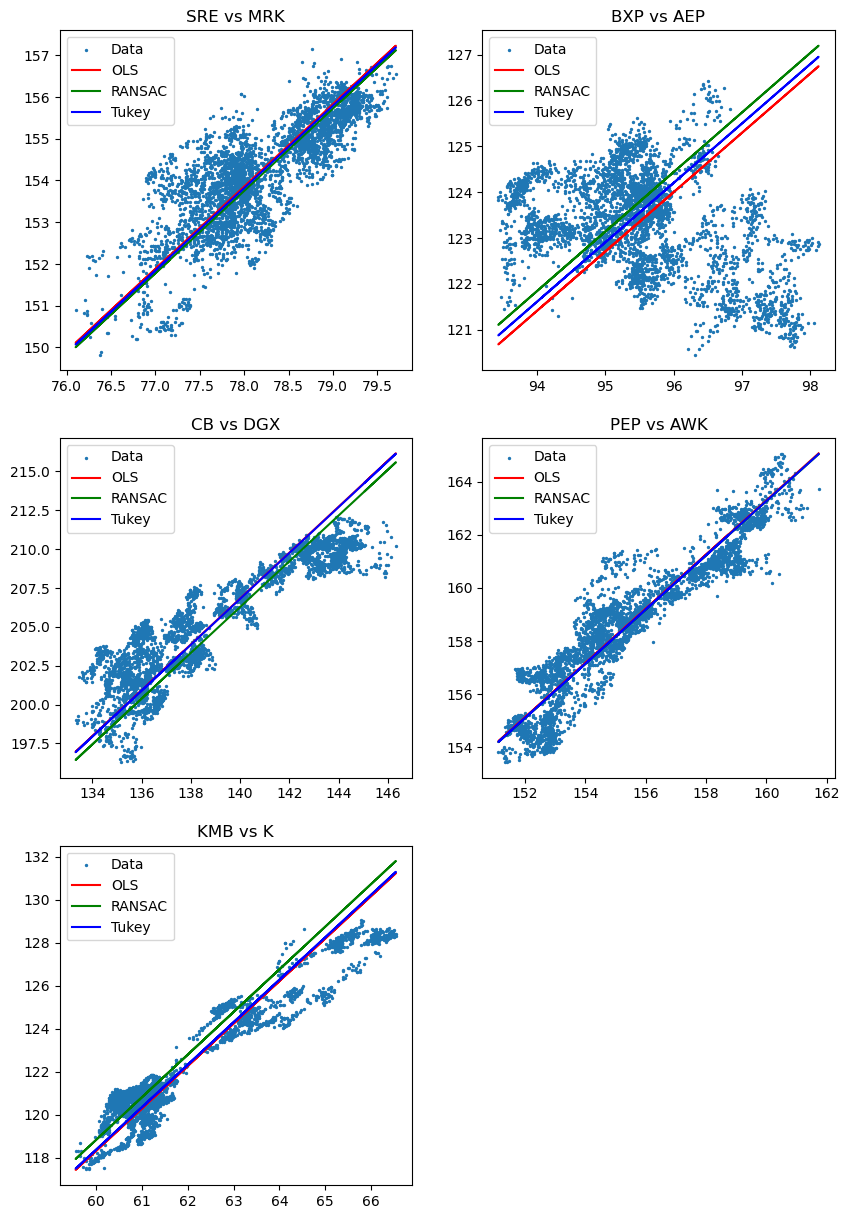

In [23]:
# Import RANSAC and LinearRegression
from sklearn.linear_model import RANSACRegressor, LinearRegression

# Read SPY data
spy = pd.read_csv('../data/monthly/prices_spy_Mar_2022.csv', parse_dates=[0], index_col=0)
spy = spy.rename({'price': 'SPY'}, axis=1)
spy_is = spy.loc[start:end]
spy_oos = spy.loc[end:trading_end]

spy_joined = formation_price.join(spy_is, how='inner')
spy_joined_oos = trading_price.join(spy_oos, how='inner')

counter = 1
n = len(pairs_selected)

fig, axs = plt.subplots((n//2)+1, 2, figsize=(10, 5 * ((n//2)+1)))

beta_dict = {}

for x in range((n//2)+1):
    for y in range(2):
        if counter == ((n//2)+1)*2:
            # Make last plot invisible
            axs[x, y].axis('off')
            fig.delaxes(axs[x, y])
            break

        # Get the top pair.
        pair_leg_1 = pairs_selected[counter - 1][0]
        pair_leg_2 = pairs_selected[counter - 1][1]

        leg_1_px = spy_joined[pair_leg_1]
        leg_2_px = spy_joined[pair_leg_2]

        axs[x, y].scatter(leg_2_px, leg_1_px, label='Data', s=2)

        # Fit ols and plot
        ols = LinearRegression(fit_intercept=False)
        ols.fit(leg_2_px.values.reshape(-1, 1), leg_1_px.values.reshape(-1, 1))
        axs[x, y].plot(leg_2_px, ols.predict(leg_2_px.values.reshape(-1, 1)), label='OLS', c='r')
        beta_dict[(pair_leg_1, pair_leg_2)] = [ols.coef_[0][0]]

        # Fit RANSAC and plot
        ransac = RANSACRegressor(estimator=LinearRegression(fit_intercept=False))
        ransac.fit(leg_2_px.values.reshape(-1, 1), leg_1_px.values.reshape(-1, 1))
        axs[x, y].plot(leg_2_px, ransac.predict(leg_2_px.values.reshape(-1, 1)), label='RANSAC', c='g')
        beta_dict[(pair_leg_1, pair_leg_2)].append(ransac.estimator_.coef_[0][0])

        # Fit Tukey and Plot
        from statsmodels.robust.norms import TukeyBiweight
        from statsmodels.api import RLM
        tukey = RLM(leg_1_px,leg_2_px , M=TukeyBiweight())
        tukey_fit = tukey.fit()
        axs[x,y].plot(leg_2_px, tukey_fit.predict(leg_2_px), label='Tukey', c='b')
        beta_dict[(pair_leg_1, pair_leg_2)].append(tukey_fit.params[0])
        
        axs[x, y].set_title(f'{pair_leg_1} vs {pair_leg_2}')
        axs[x, y].legend()

        counter += 1
plt.show()

It is perhaps unsurprising that all three models perform very similarly, and have very similar betas, but this varies by pair. The biggest difference is seen in FIS vs. WTW, where all three models have quite different betas. However, using a robust regression gives us a better chance of constructing a somewhat stationary timeseries out of sample, which is the primary goal of this step. Let's compare how they do out of sample via their OOS R^2 scores.

In [24]:
# Calculate OOS R^2 for each beta
from sklearn.metrics import r2_score

r2s = {'OLS': {}, 'RANSAC': {}, 'Tukey': {}}

for pair in pairs_selected:
    # OLS
    r2s['OLS'][pair] = r2_score(spy_joined_oos[pair[0]], spy_joined_oos[pair[1]] * beta_dict[pair][0])
    # RANSAC
    r2s['RANSAC'][pair] = r2_score(spy_joined_oos[pair[0]], spy_joined_oos[pair[1]] * beta_dict[pair][1])
    # Tukey
    r2s['Tukey'][pair] = r2_score(spy_joined_oos[pair[0]], spy_joined_oos[pair[1]] * beta_dict[pair][2])

r2s_df = pd.DataFrame(r2s, index=pairs_selected)
display(r2s_df)

OLS    RANSAC     Tukey
(SRE, MRK)  0.392119  0.327530  0.369052
(BXP, AEP) -1.738265 -1.033200 -1.395347
(CB, DGX)  -0.559518 -0.905735 -0.571855
(PEP, AWK) -4.496675 -4.588433 -4.570236
(KMB, K)   -4.626431 -5.953596 -4.712235

We see that RANSAC and Tukey perform very similarly, although RANSAC performs better in all cases except for (MRK, SRE) and (WMB, XRAY). Notably, though, this shows the risk we run when using this method to calculate the out of sample spread, since most of the R^2s are negative.

In [25]:
from backtest.hedging import beta_calc

print(f'Hedge Ratios (regression betas):')
betas = {}
for pair in pairs_selected:
    betas[pair] = beta_calc(spy_joined[pair[0]], spy_joined[pair[1]], spy_joined['SPY'], mod=3)[0]
    print(f'  -{pair[0]}-{pair[1]}: {betas[pair]:,.4f}')
beta = betas[pairs_selected[0]]

Hedge Ratios (regression betas):
  -SRE-MRK: 1.9717
  -BXP-AEP: 1.2959
  -CB-DGX: 1.4729
  -PEP-AWK: 1.0204
  -KMB-K: 1.9785


# 4. Backtesting

In order to assess the performance of the strategy and test its sensitivity to changes in formation period length, response delay, trading costs, et cetera, we implement a conservative simulation of trading the strategy. We begin by simulating a single pair, traded over a specified period. This is later looped to test more pairs and trading periods.

In [26]:
from backtest.backtester import simulate_pair
from scipy.optimize import minimize_scalar

sizes = pd.read_csv('../data/monthly/sizes_Mar_2022.csv', parse_dates=[0], index_col=0)
sizes = sizes.ffill()
formation_sizes = sizes.loc[start:end]
trading_sizes = sizes.loc[end:trading_end]

## 4.1 Trading a single pair

Having, as described above, obtained related pairs and copulae, generated trading signals and calculated hedging ratios to achieve market neutrality, we feed this data into the single pair backtester- a function that simulates trading based on the data provided. <br>

A number of conservative assumptions are made in relation to funding and execution.<br>
We aim to execute positions with a notional of, by default, 10% of the available cash. This can go up to 30% based on signal strength. Note that, since no cash changes hands when opening a short position, a smaller fraction of cash is actually paid when opening a position. <br>

Due to the frequency of our trading, we have to take special care with liquidity and our ability to execute. Our approach to this is twofold: <br>
- We limit the number of shares we execute to be, at most, 5% of the available liquidity (of the less liquid leg of the pair).
- To account for our inability to execute all our volume at once and at the prevailing price, we assume execution at VWAP. <br>

When closing positions, we are mindful of the time it may take to close out. We do not enter any new positions until our position is fully unwound and we assume that this happens only once the available liquidity is at least 20 times greater than what we need to execute. Again, we assume execution at VWAP. <br>

We also close any positions at the end of every week, given that overnight positions already introduce more than enough jumps in the data, we want to mitigate this where possible. Although this introduces additional trading costs, it reduces the risk of larger jumps in the data, and allows us to re-estimate pairs for the next week. <br>

We assume that our short position yields us (annualized) Fed Funds Rate (FFR) + 50bps on the notional. If we end up having to borrow cash to close out a short, we assume we pay FFR on the amount of cash borrowed. <br>

Additionally, we assume that we are unable to react to a signal instantaneously. As such, we impose a delay between signal reception and our attempt to act on it. A variable transaction cost is paid on the notional of every position opened/closed.<br>

The combination of
- Never executing more than 5% of the available liquidity
- Using VWAP
- Imposing a variable delay on our reaction to a signal

Makes our results very conservative with respect to reacting time and liquidity.

## 4.2 Trading Multiple Pairs

We run up to 5 pairs in a single trading period, so the returns for our entire portfolio are calculated based off of the returns of the 5 individual pairs. Since we have already checked for overlap in pairs during the pair selection process, we don't run the risk of having multiple long and/or short positions in the same stock <br>

The starting capital is then scaled by the previously calculated weights of the in-sample period. Finally, the returns are aggregated to get the returns of the portfolio. Adjustments for leverage are done *ex-post*, to speed up computation, given that it is a vectorized operation. <br>

*NOTE: Due to the runtime limitations for optimizing mixed copulas, fitting single copulas, and calculating weights, we only analyze 3 full years of backtesting*



## 4.3 Example and Analysis

In [27]:
signal_object = SignalGeneration(price, pairs_selected, start, end, trading_end, copula_type = ["gumbel","clayton"], n= 200)
sig1, sig2 = signal_object.calc_signals(single = False)

### 4.3.1 Backtesting Example

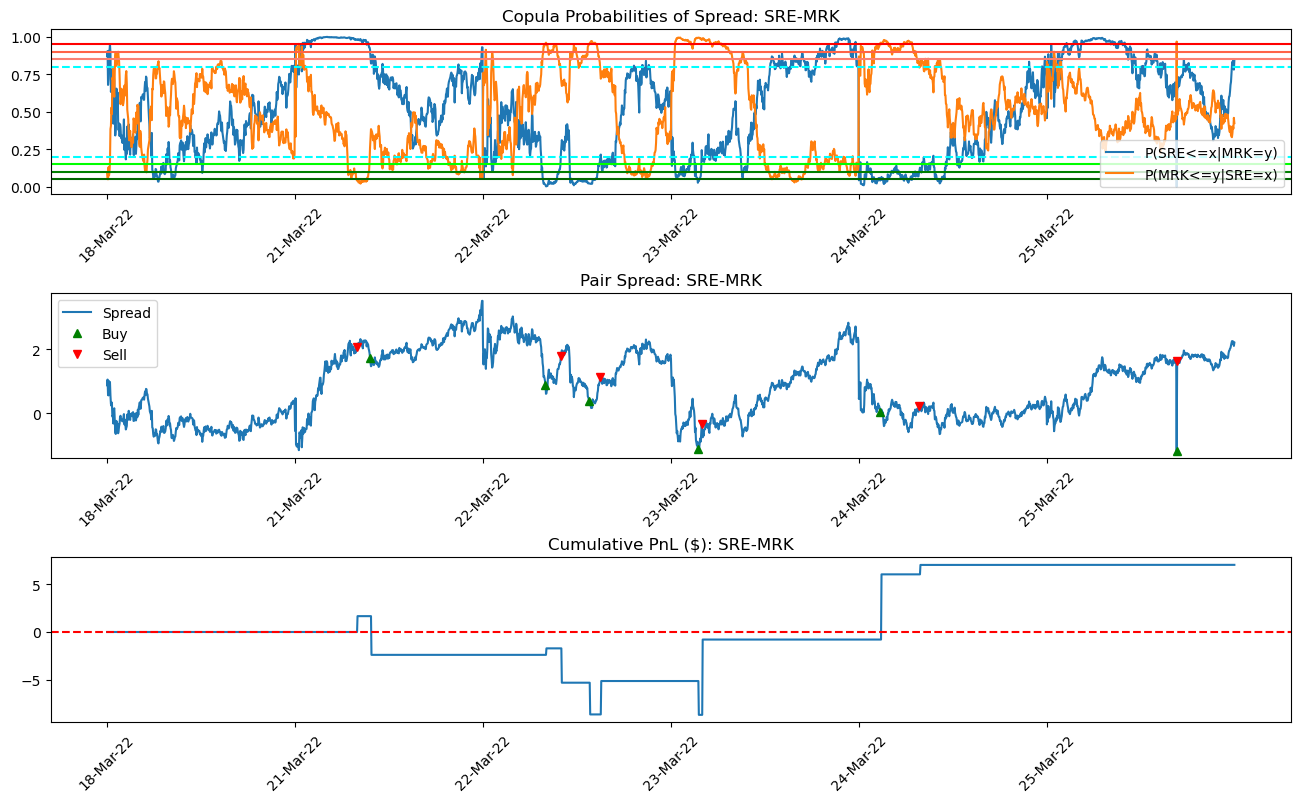

In [64]:
pair = pairs_selected[0]

signals = signal_object.generate_signals(sig1 = sig1[pair], sig2 = sig2[pair])
signals = pd.DataFrame(data=signals['Signal'].values, index=trading_price.index, columns=['Signal'])

pair_leg_1 = pair[0]
pair_leg_2 = pair[1]
beta = betas[pair]

execution_delay = 1
prepped = pd.DataFrame(
    data={
        f'Leg 1 VWAP {execution_delay}': trading_price[pair_leg_1],
        f'Leg 2 VWAP {execution_delay}': trading_price[pair_leg_2],
        f'Volume 1': trading_sizes[pair_leg_1],
        f'Volume 2': trading_sizes[pair_leg_2],
        f'Leg 1 VWAP Volume {execution_delay}': trading_sizes[pair_leg_1],
        f'Leg 2 VWAP Volume {execution_delay}': trading_sizes[pair_leg_2],
        f'Signal {execution_delay}': signals['Signal'].shift(1).fillna(0),
        'Betas': beta,
        'FFR': 0.01
    }
)
backtest_res = simulate_pair(prepped, K=50_000, delay_time=execution_delay)

plot_backtested(pair, trading_price, signals, beta, sig1, sig2, backtest_res)

### 4.3.2 Transaction cost analysis

From the example pairs, we calculated breakeven level of transactioncosts. Two of the pairs are profitable with 3bps transaction costs but not the others. SRE and MRK pair showed a positive return with transaction costs, but since it had more frequent trading, around 0.5% basis point transaction costs is enough to make it even to 0.

In [32]:
display(pd.read_csv("./data/cost_analysis/transact_cost.csv", index_col=(0,1)))

Breakeven Cost  Sample Return  The Number of Trading
SRE MRK        0.000047       0.033790                     12
BXP AEP        0.000382       0.040923                      2
CB  DGX        0.000005      -0.125886                     10
PEP AWK        0.000331       0.145380                      7
KMB K          0.000005      -0.022268                      5

### 4.3.3 Stop loss analysis

We assumed the symmetric exit threshold for upper and lower bounds of the spread. Below graph shows how the return changes with the lower exit threshold.

Depends on the pair the exit threshold that makes the return 0 is different. At the same time the plot shows that this is not a convex problem, so it is hard to define the optimal threshold. 

In [33]:
import pickle
with open(f'./data/cost_analysis/stop_loss_series.pickle', 'rb') as f:
    stop_loss_plot = pickle.load(f)

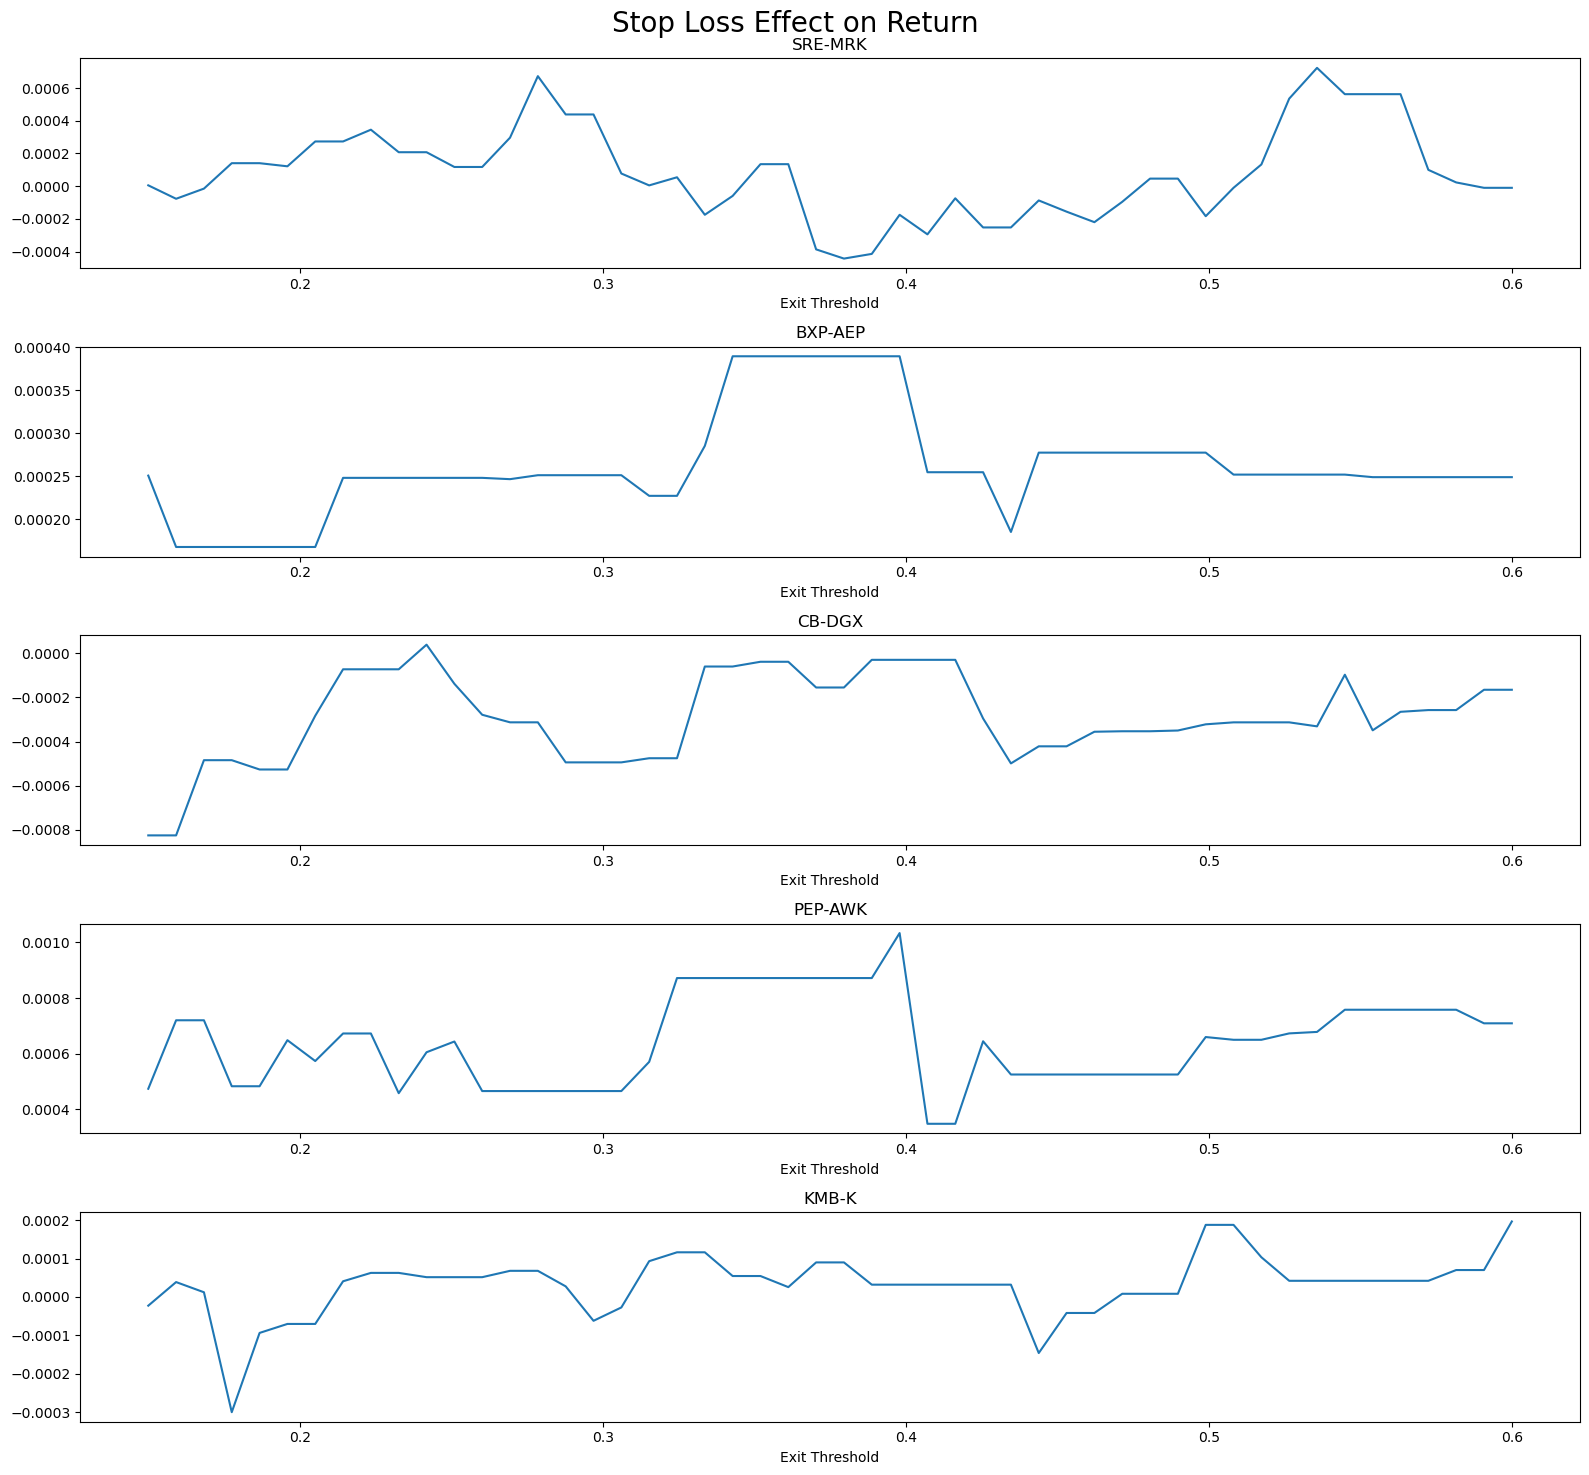

In [34]:
fig, ax = plt.subplots(figsize=(16,15), nrows=len(pairs_selected), ncols=1)
for ind, pair in enumerate(pairs_selected):
    ax[ind].plot(stop_loss_plot[pair], label=pair)
    ax[ind].set_title(f'{pair[0]}-{pair[1]}')
    ax[ind].set_xlabel('Exit Threshold')
fig.suptitle('Stop Loss Effect on Return', fontsize=20)
fig.tight_layout()

### 4.3.4 Execution delay analysis

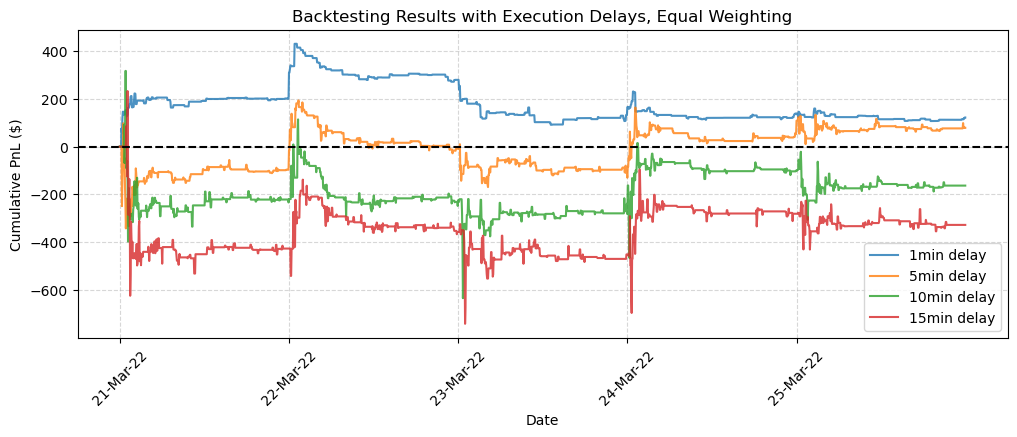

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))

delays = [1, 5, 10, 15]
c = 'gumbel'

for delay in delays:
    result = pd.read_csv(f'./data/backtest_results/gumbel_2022_WEEK_10_DELAY_{delay}.csv', index_col=0, parse_dates=True)

    # Only get columns with "Portfolio" in the column name
    result = result.filter(regex='Portfolio').sum(axis=1)
    x_minutes = result.index
    x_plot = range(0, len(x_minutes))
    x_labels = x_minutes[~x_minutes.strftime("%d").duplicated()]
    x_ticks = np.where(np.in1d(x_minutes, x_labels))[0]
    
    ax.plot(x_plot, result-1_000_000, label=f'{delay}min delay', alpha=0.8)

ax.set_xticks(x_ticks, x_labels.strftime("%d-%b-%y"), rotation=45)
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL ($)')
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
ax.set_title('Backtesting Results with Execution Delays, Equal Weighting')
plt.show()    

# 5. Portfolio Optimization and Weights

Since the seminal work of Markowitz (1952), mean-variance optimization has been the most rigorous way to pick assets in which to invest. The two fundamental ingredients are the expected return for each asset, and the covariance matrix of returns, which represents risk control.  
  
Estimating the covariance matrix of stock returns has always been one of the stickiest points. The standard statistical method is to gather a history of past returns and compute their sample covariance matrix. Unfortunately this creates problems that are well documented (Jobson and Korkie, 1980).

1. **Outliers**: The sample covariance matrix can be sensitive to outliers in the data, which can have a significant impact on the covariance estimates. This can lead to inaccurate estimates of risk and return and suboptimal portfolio allocations.

2. **Limited Sample Size**: The sample covariance matrix is based on a limited sample size, which can lead to estimation error and inaccuracies in the estimates of risk and return. This is especially true when the number of assets in the portfolio is large relative to the sample size.

3. **Non-stationarity**: Financial markets are known to be non-stationary, meaning that the statistical properties of the data change over time. The sample covariance matrix assumes that the data is stationary, which can lead to inaccurate estimates of risk and return if the data exhibits non-stationarity.  
*NOTE: This should not be a big issue for the underlying "assets" of our portfolio, since the assets are spreads which are designed in a manner that they be stationary.*

4. **Correlated Assets**: Finally, the sample covariance matrix assumes that the assets in the portfolio are uncorrelated or have a constant correlation over time. However, in practice, assets can be highly correlated, and the correlation can change over time. This can lead to inaccurate estimates of risk and return and suboptimal portfolio allocations.  
*NOTE: This also turns out to not a deal breaker for our portfolio as it is essential low-beta arb strat making the individual assets, in theory, highly uncorrelated. We shall talk about this in detail*


To address these issues, more sophisticated techniques such as shrinkage estimators, or robust estimators can be used to estimate the covariance matrix and construct a portfolio. These methods can improve the accuracy of the covariance estimates and lead to better portfolio allocations.

## 5.1 Covariance Estimation

In [39]:
from portfolio.different_covariances import Covariances

In [42]:
weekly_returns = {}
for pair in pairs_selected:
    weekly_returns[pair] = (formation_price[pair[0]] - formation_price[pair[1]] * betas[pair]).drop_duplicates().pct_change().dropna()

pair_returns = pd.DataFrame(weekly_returns)
cov = Covariances(pair_returns)

### 5.1.1 Sample Covariance Matrix

In [43]:
display(cov.emp_covariance)

SRE        BXP        CB         PEP        KMB
               MRK        AEP       DGX         AWK          K
SRE MRK  40.113306   0.066422  0.106091   -0.866009  -0.064155
BXP AEP   0.066422  54.257038  0.041986   -0.177550   0.003073
CB  DGX   0.106091   0.041986  2.185568    0.197557  -0.005172
PEP AWK  -0.866009  -0.177550  0.197557  168.033395  -0.087773
KMB K    -0.064155   0.003073 -0.005172   -0.087773  14.736293

### 5.1.2 Marcenko-Pastur Denoising
The main idea behind de-noising the covariance matrix is to eliminate the eigenvalues of the covariance matrix that are representing noise and not useful information.  
  
This is done by determining the maximum theoretical value of the eigenvalue of such matrix as a threshold and then setting all the calculated eigenvalues below the threshold to the same value.
  
The function developed for de-noising the covariance works as follows:
1. The given covariance matrix is transformed to the correlation matrix.
2. The eigenvalues and eigenvectors of the correlation matrix are calculated.
3. Using the Kernel Density Estimate algorithm a kernel of the eigenvalues is estimated.
4. The Marcenko-Pastur pdf is fitted to the KDE estimate using the variance as the parameter for the optimization.
5. From the obtained Marcenko-Pastur distribution, the maximum theoretical eigenvalue is calculated.
6. The eigenvalues in the set that are above the theoretical value are all set to their average value. For example, we have a set of 5 sorted eigenvalues $(\lambda_1, \lambda_2, ....., \lambda_5)$ two of which are below the maximum theoretical value, then we set
$$
\lambda^{NEW}_{1}=\lambda^{NEW}_{2}=\frac{\lambda^{OLD}_{1} + \lambda^{OLD}_{1}}{2}
$$
Eigenvalues above the maximum theoretical value are left intact.
$$
\lambda^{NEW}_{3}=\lambda^{OLD}_{3} \\
\lambda^{NEW}_{4}=\lambda^{OLD}_{4} \\
\lambda^{NEW}_{5}=\lambda^{OLD}_{5} 
$$
7. The new set of eigenvalues with the set of eigenvectors is used to obtain the new de-noised correlation matrix. $\tilde{C}$ is the de-noised correlation matrix, $W$ is the eigenvectors matrix, and $\Lambda$ is the diagonal matrix with new eigenvalues.
8. The new correlation matrix is then transformed back to the new de-noised covariance matrix.
$$
\tilde{C}=WΛW
$$
9. To rescale $\tilde{C}$ so that the main diagonal consists of 1s the following transformation is made. This is how the final $C_{denoised}$ is obtained.
$$
C_{denoised}=C[diag[C]^{\frac{1}{2}}diag[C]^{\frac{1}{2}'}]^{−1}
$$
10. The new correlation matrix is then transformed back to the new de-noised covariance matrix.

In [44]:
display(cov.mp_covariance)

SRE           BXP            CB           PEP           KMB
                  MRK           AEP           DGX           AWK             K
SRE MRK  4.011331e+01 -2.006199e-14 -4.088434e-15  2.167596e-14  5.645237e-15
BXP AEP -2.087318e-14  5.425704e+01 -1.373742e-15  1.353181e-14  4.050648e-15
CB  DGX -4.092678e-15 -1.262077e-15  2.185568e+00 -2.765207e-15 -1.926425e-16
PEP AWK  2.614874e-14  1.384235e-14 -2.736757e-15  1.680334e+02  2.725443e-15
KMB K    6.537759e-15  2.949116e-15 -1.643783e-16  2.141559e-15  1.473629e+01

### 5.1.3 Ledoit-Wolf Shrinkage
The idea behind Ledoit-Wolf shrinkage is to use a combination of the sample covariance matrix and a target matrix to create a new covariance estimate. Suppose we have a dataset of $n$ observations of $p$ variables, represented by an $n \times p$ data matrix $X$. Our goal is to estimate the covariance matrix $\Sigma$ of the variables.

The sample covariance matrix is given by:

$$S = \frac{1}{n-1}X^T X$$

However, when $p$ is large relative to $n$, $S$ can be a poor estimator of $\Sigma$ due to its high variance and potential instability. The Ledoit-Wolf shrinkage method addresses this problem by "shrinking" $S$ towards a target matrix $T$ that better reflects our assumptions about the structure of $\Sigma$.

The shrunk estimator is given by:

$$\hat{\Sigma} = \delta T + (1-\delta)S$$

where $\delta$ is the shrinkage intensity parameter, which controls the amount of shrinkage. When $\delta=1$, we have the target matrix $T$ and no shrinkage occurs. When $\delta=0$, we have the sample covariance matrix $S$ with no shrinkage.

The target matrix $T$ is chosen based on assumptions about the structure of $\Sigma$. One common choice is the diagonal matrix with the sample variances on the diagonal, which assumes that the variables are uncorrelated with equal variances. Another choice is the identity matrix, which assumes that the variables are uncorrelated with unit variances. This is especially true in our scenario, as in theory, these spread returns should be uncorrelated, except in scenarios when there is mispricing because of some kind of stress in the market, thus, making this kind of a shrinkage based estimation of the covariance matrix our top choice.

The shrinkage intensity parameter $\delta$ can be estimated by minimizing the following objective function:

$$\text{minimize } \text{trace}((\delta T + (1-\delta)S - \Sigma)^2) + \lambda \delta^2 \text{trace}(T^2)$$

where $\lambda$ is a tuning parameter that controls the tradeoff between bias and variance in the estimate. This objective function balances the fit of the estimator to the data (first term) with the degree of shrinkage (second term).

The solution to this optimization problem is given by:

$$\hat{\delta} = \frac{\text{tr}(S-T)}{|S-T|_F^2/n}$$

where $\text{tr}(\cdot)$ is the trace operator, $| \cdot |_F$ is the Frobenius norm, and $n$ is the number of observations.

Once we have estimated the shrunk covariance matrix $\hat{\Sigma}$, we can use it in a variety of applications, such as portfolio optimization, factor analysis, and hypothesis testing. The Ledoit-Wolf shrinkage method is a powerful tool for improving the accuracy and stability of these applications, particularly when $p$ is large relative to $n$.

In [45]:
display(cov.lw_covariance)

SRE         BXP          CB          PEP         KMB
                MRK         AEP         DGX          AWK           K
SRE MRK  765.582909  -30.886890   -1.144196  -109.948903   -8.691642
BXP AEP  -30.886890  843.253261   -1.840625  -136.053505  -11.603027
CB  DGX   -1.144196   -1.840625  670.263242    -3.741462   -0.549822
PEP AWK -109.948903 -136.053505   -3.741462  2335.337575  -37.004344
KMB K     -8.691642  -11.603027   -0.549822   -37.004344  682.841637

In [46]:
def pair_string(x):
    x = re.findall('\w+', x)
    return f"{x[0]}_{x[1]}"

def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1] = -1, 1 # numerical error 
    return corr

covariances = {'Empirical': cov.emp_covariance, 
                'LedoitWolf':cov.lw_covariance, 
                'MarcenkoPastur':cov.mp_covariance}

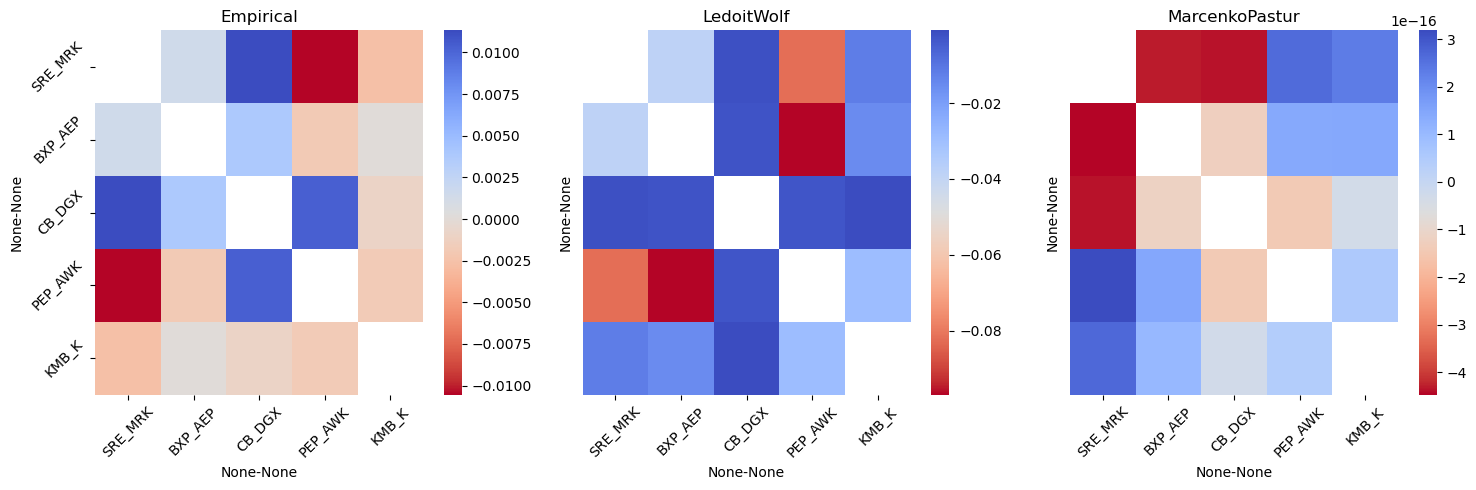

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, matrix) in enumerate(covariances.items()):
    label = [f'{x[0]}_{x[1]}' for x in matrix.columns]
    cor = cov2corr(matrix)
    cor[round(cor,2)==1] = np.nan
    yticklabels = label if i==0 else False
    sns.heatmap(cor, ax = ax[i], annot=False, yticklabels=yticklabels, cmap='coolwarm_r')
    if yticklabels:
        ax[i].set_yticklabels(yticklabels, rotation=45)
    ax[i].set_xticklabels(label, rotation=45)
    ax[i].set_title(name)

fig.tight_layout()

## 5.2 Optimization and Weights
### 5.2.1 Benchmark Weights - Equal Portfolio
This strategy is essentially a low beta arbitrage strategy aiming to capture small market inefficiencies that exist due to temporary mispricings in the market, an equally weighted portfolio exposing to each indvidual asset makes sense. Since the assets in the portfolio, in theory, are highly uncorrelated, an equally weighted portfolio provides equal exposure to each asset. This means that each asset contributes equally to the portfolio's performance, and no single asset dominates the portfolio. This avoids concentration risk and creates a diversified portfolio. We choose this as our bechmark portfolio weights.

### 5.2.2 Optimizer

In [48]:
from portfolio.portfolio_optimization import get_constrained_weights

- We first define the objective function to be maximized, which is the negative Sharpe ratio of the portfolio. The Sharpe ratio is the ratio of the portfolio's expected excess return to its standard deviation, and we negate it to turn the maximization problem into a minimization problem. 
- We then define the equality constraint that the weights must sum to 1, and the inequality constraints that each weight must be between 0 and 1. We also define an initial guess for the weights, which is an equal weighting for all assets.
- We then use the minimize function from the scipy.optimize library to minimize the negative Sharpe ratio subject to the constraints. We use the Sequential Least Squares Programming (SLSQP) method for optimization.
- The result of the optimization is an array of weights for each asset in the portfolio that maximizes the Sharpe ratio. The weights represent the proportion of the total portfolio value that is allocated to each asset.

### 5.2.3 Weights

SRE_MRK   BXP_AEP  CB_DGX   PEP_AWK     KMB_K
Equal           2.000000e-01  0.200000     0.2  0.200000  0.200000
Empirical       1.341329e-17  0.047817     0.0  0.233884  0.718300
LedoitWolf      3.103168e-18  0.174940     0.0  0.428571  0.396489
MarcenkoPastur  1.187931e-18  0.048260     0.0  0.236143  0.715597

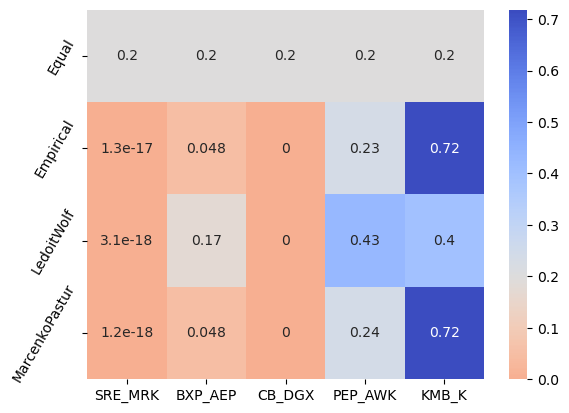

In [49]:
n_assets = pair_returns.shape[1]
mu = pair_returns.mean()

weights = {}
weights['Equal'] = np.ones(n_assets)/n_assets

for t, cov in covariances.items():
    w = get_constrained_weights(cov, mu)
    weights[t] = w

weightdf = pd.DataFrame(weights, index=label).T
display(weightdf)

fig, ax = plt.subplots()
sns.heatmap(weightdf, cmap='coolwarm_r', center=0.2, annot=True, ax=ax)
ax.set_yticklabels(weightdf.index, rotation=60)
plt.show()

In [50]:
# weightdf.to_csv('demo_weights.csv')
bt = pd.read_csv('./data/backtest_results/clayton_2022_WEEK_10_DELAY_3.csv', parse_dates=[0], index_col=0, usecols=[0, 5, 10, 15, 20, 25])
bt.columns = weightdf.columns
bt = bt.pct_change().dropna()
portfolio = pd.DataFrame()
for i in weightdf.index:
    portfolio[i] = (bt * weightdf.loc[i]).sum(axis=1)
portfolio
perf_summ(portfolio, 252*6.5*60).T

Equal            Empirical  \
Annualized Return                    0.018891             0.001549   
Annualized Volatility                0.002536             0.003157   
Annualized Sharpe Ratio              7.447968             0.490804   
Annualized Sortino Ratio             4.279852             0.177225   
Skewness                             2.834839            -9.810847   
Excess Kurtosis                     84.487044           359.629222   
VaR (0.05)                          -0.000004                 -0.0   
CVaR (0.05)                         -0.000016            -0.000016   
Min                                 -0.000103            -0.000285   
Max                                  0.000129             0.000128   
Max Drawdown                        -0.000264            -0.000349   
Calmar Ratio                        71.559139             4.441107   
Peak                      2022-03-22 09:48:00  2022-03-22 09:48:00   
Bottom                    2022-03-23 11:24:00  2022-03-23 09:33:00   
Recovery                  2022-03-24 09:45:00    Not yet recovered   

                                   LedoitWolf       MarcenkoPastur  
Annualized Return                   -0.005373             0.001501  
Annualized Volatility                0.002601             0.003146  
Annualized Sharpe Ratio             -2.065757             0.476941  
Annualized Sortino Ratio            -0.761456             0.172284  
Skewness                            -7.539274            -9.795843  
Excess Kurtosis                    195.956814            358.88675  
VaR (0.05)                               -0.0                 -0.0  
CVaR (0.05)                         -0.000016            -0.000016  
Min                                  -0.00018            -0.000283  
Max                                  0.000083             0.000127  
Max Drawdown                        -0.000315            -0.000348  
Calmar Ratio                        17.083585               4.3072  
Peak                      2022-03-21 09:31:00  2022-03-22 09:48:00  
Bottom                    2022-03-23 09:53:00  2022-03-23 09:33:00  
Recovery                    Not yet recovered    Not yet recovered

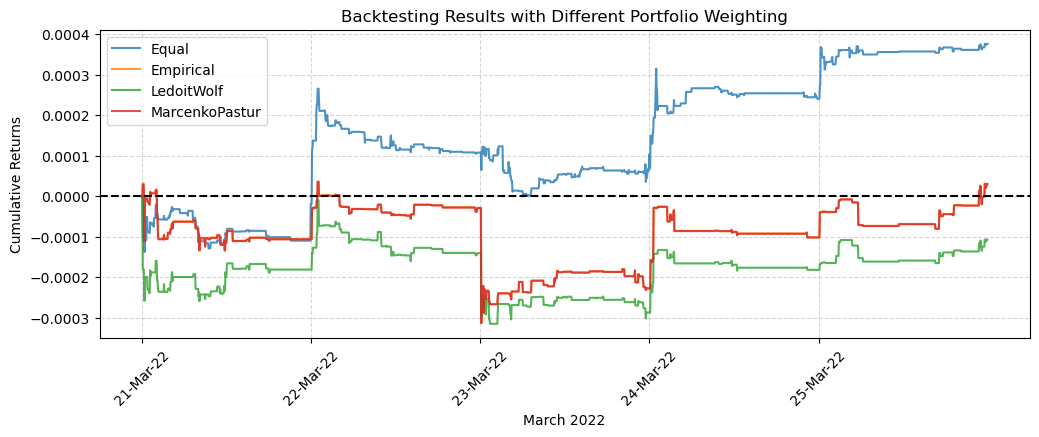

In [51]:
cumreturns = ((1+portfolio).cumprod()-1)
fig, ax = plt.subplots(figsize=(12, 4))

for c in cumreturns.columns:
    y = cumreturns[c]
    x_minutes = y.index
    x_plot = range(0, len(x_minutes))
    x_labels = x_minutes[~x_minutes.strftime("%d").duplicated()]
    x_ticks = np.where(np.in1d(x_minutes, x_labels))[0]
    
    ax.plot(x_plot, y, label=c, alpha=0.8)

ax.set_xticks(x_ticks, x_labels.strftime("%d-%b-%y"), rotation=45)
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('March 2022')
ax.set_ylabel('Cumulative Returns')
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
ax.set_title('Backtesting Results with Different Portfolio Weighting')
plt.show()    

***
# 6. Results

## 6.1 Copulae Selection

It is quite clear from the results that the mixed copula gives better return than either of the Gumbel or Clayton copulae. However, it is quite volatile and thus does not have higher Sharpe ratio than the other two except for in 2022. Sharpe ratio considers the complete volatility and not just the downside volatility of the returns. Sortino ratio paints a different picture, showing that the mixed copula has a much higher Sortino in both 2021 and 2022. This is good as we do want want to penalize ourselves for positive volatility in an arbitrage strategy.

In [53]:
copulae = ['mixed', 'gumbel', 'clayton']
pd.read_csv('./data/results/copulae_overnight.csv', index_col=[0,1]).T

Year                                   2020                       \
Copulae                               Mixed               Gumbel   
Annualized Return                  3.244989             0.025732   
Annualized Volatility              2.993254             0.009272   
Annualized Sharpe Ratio            1.084101             2.775123   
Annualized Sortino Ratio           1.937042             4.458479   
Skewness                          10.501353             2.639302   
Excess Kurtosis                  163.228895            30.895674   
VaR (0.05)                        -0.000868            -0.000445   
CVaR (0.05)                       -0.097495            -0.000868   
Min                               -1.109951            -0.003289   
Max                                2.656305             0.005203   
Max Drawdown                      -1.201605            -0.005762   
Calmar Ratio                       2.700546             4.466084   
Peak                             2020-08-05           2020-01-23   
Bottom                           2020-11-04           2020-03-13   
Recovery                  Not yet recovered  2020-03-17 00:00:00   

Year                                                          2021  \
Copulae                               Clayton                Mixed   
Annualized Return                    0.026678             7.044392   
Annualized Volatility                0.008553             4.068805   
Annualized Sharpe Ratio              3.119084             1.731317   
Annualized Sortino Ratio             5.376616          2302.936432   
Skewness                             1.706837            10.540169   
Excess Kurtosis                     12.782894            111.81568   
VaR (0.05)                          -0.000546             -0.00038   
CVaR (0.05)                         -0.000906            -0.000617   
Min                                 -0.002292            -0.001086   
Max                                  0.003786             2.936284   
Max Drawdown                        -0.003752            -0.003015   
Calmar Ratio                         7.110278          2336.331188   
Peak                               2020-03-11           2021-01-19   
Bottom                             2020-03-13           2021-03-01   
Recovery                  2020-03-17 00:00:00  2021-03-16 00:00:00   

Year                                                                \
Copulae                                Gumbel              Clayton   
Annualized Return                    0.013873             0.011696   
Annualized Volatility                0.006478              0.00489   
Annualized Sharpe Ratio              2.141561             2.392099   
Annualized Sortino Ratio             2.524448             3.896264   
Skewness                             0.170928             0.511408   
Excess Kurtosis                     22.842329             3.844386   
VaR (0.05)                          -0.000422             -0.00041   
CVaR (0.05)                         -0.000815            -0.000604   
Min                                 -0.002808            -0.001037   
Max                                  0.003005             0.001679   
Max Drawdown                        -0.002808            -0.002449   
Calmar Ratio                         4.940692             4.775129   
Peak                               2021-03-04           2021-10-13   
Bottom                             2021-03-05           2021-11-30   
Recovery                  2021-05-11 00:00:00  2021-12-13 00:00:00   

Year                                     2022                       \
Copulae                                 Mixed               Gumbel   
Annualized Return                    2.387935             0.270407   
Annualized Volatility                1.919068             0.494846   
Annualized Sharpe Ratio               1.24432             0.546447   
Annualized Sortino Ratio           331.376184             0.887694   
Skewness                            14.71

## 6.2 Overnight vs Daily

Most of our returns are coming from overnight holding. This can be attributed to the jump between the closing price and opening price so which regards to how the stocks are affected by the market overnight.

This phenomenon is prominent in mixed copula, where the returns showing 200% to 700% by years. For gumbel and clayton single copula, 2022 and 2021 are the years that overnight returns are slightly higher than 0, while returns from daytime are lower than 0. For single copulas, 2022 is the year that daytime trading have higher than overnight returns.

In [54]:
for c in copulae:
    print(c.capitalize())
    display(pd.read_csv(f'./data/results/return_type_{c}.csv', index_col=[0,1]).T.iloc[:-7])

Mixed


Year                            2020                    2021             \
Return Type                Overnight      Daily    Overnight      Daily   
Annualized Return           3.244989  -0.781313     7.044392  -0.983835   
Annualized Volatility       2.993254   0.641686     4.068805    0.34735   
Annualized Sharpe Ratio     1.084101  -1.217593     1.731317  -2.832401   
Annualized Sortino Ratio    1.937042  -1.358941  2302.936432  -2.140596   
Skewness                   10.501353   3.899652    10.540169  -6.590554   
Excess Kurtosis           163.228895  82.556706    111.81568  46.948136   
VaR (0.05)                 -0.000868  -0.002225     -0.00038  -0.000708   
CVaR (0.05)                -0.097495  -0.094134    -0.000617  -0.074099   

Year                            2022             
Return Type                Overnight      Daily  
Annualized Return           2.387935  -0.423329  
Annualized Volatility       1.919068   0.228219  
Annualized Sharpe Ratio      1.24432  -1.854924  
Annualized Sortino Ratio  331.376184  -1.401279  
Skewness                   14.713187 -10.534315  
Excess Kurtosis           219.584545  119.46363  
VaR (0.05)                 -0.000577  -0.000601  
CVaR (0.05)                -0.001238  -0.032181

Gumbel


Year                           2020                  2021            \
Return Type               Overnight      Daily  Overnight     Daily   
Annualized Return          0.025732  -0.021985   0.013873 -0.013266   
Annualized Volatility      0.009272    0.00896   0.006478  0.006419   
Annualized Sharpe Ratio    2.775123  -2.453804   2.141561 -2.066569   
Annualized Sortino Ratio   4.458479  -2.587812   2.524448 -2.707318   
Skewness                   2.639302  -2.202495   0.170928 -0.026496   
Excess Kurtosis           30.895674  27.204502  22.842329  23.54589   
VaR (0.05)                -0.000445   -0.00075  -0.000422 -0.000525   
CVaR (0.05)               -0.000868  -0.001523  -0.000815   -0.0009   

Year                            2022              
Return Type                Overnight       Daily  
Annualized Return           0.270407    0.924751  
Annualized Volatility       0.494846    0.944513  
Annualized Sharpe Ratio     0.546447    0.979077  
Annualized Sortino Ratio    0.887694    4.140332  
Skewness                    9.482474   13.590228  
Excess Kurtosis           132.860197  195.705936  
VaR (0.05)                 -0.000663   -0.000618  
CVaR (0.05)                -0.027282   -0.020474

Clayton


Year                           2020                 2021                 2022  \
Return Type               Overnight      Daily Overnight     Daily  Overnight   
Annualized Return          0.026678  -0.025595  0.011696 -0.010646   0.152312   
Annualized Volatility      0.008553   0.008444   0.00489  0.004799   0.374922   
Annualized Sharpe Ratio    3.119084  -3.031314  2.392099 -2.218308    0.40625   
Annualized Sortino Ratio   5.376616   -3.31178  3.896264 -3.041184   0.546147   
Skewness                   1.706837  -1.883328  0.511408 -0.442984    6.38495   
Excess Kurtosis           12.782894  14.913968  3.844386  4.061567  93.400538   
VaR (0.05)                -0.000546  -0.000814  -0.00041 -0.000461  -0.000624   
CVaR (0.05)               -0.000906  -0.001496 -0.000604 -0.000711  -0.026003   

Year                                  
Return Type                    Daily  
Annualized Return           0.939728  
Annualized Volatility       0.952864  
Annualized Sharpe Ratio     0.986214  
Annualized Sortino Ratio    4.336711  
Skewness                   13.605657  
Excess Kurtosis           195.485651  
VaR (0.05)                 -0.000876  
CVaR (0.05)                -0.019994

## 6.3 Execution Delay

Below graph shows the returns, computed by the change of the delay assumption. If we assume the entry threshold is the optimal point, then below graph should be downward sloping. However, the graph have two peaks, which happens when the price moved profitable direction after the entry. This means that the entry threshold was not the optimal point.

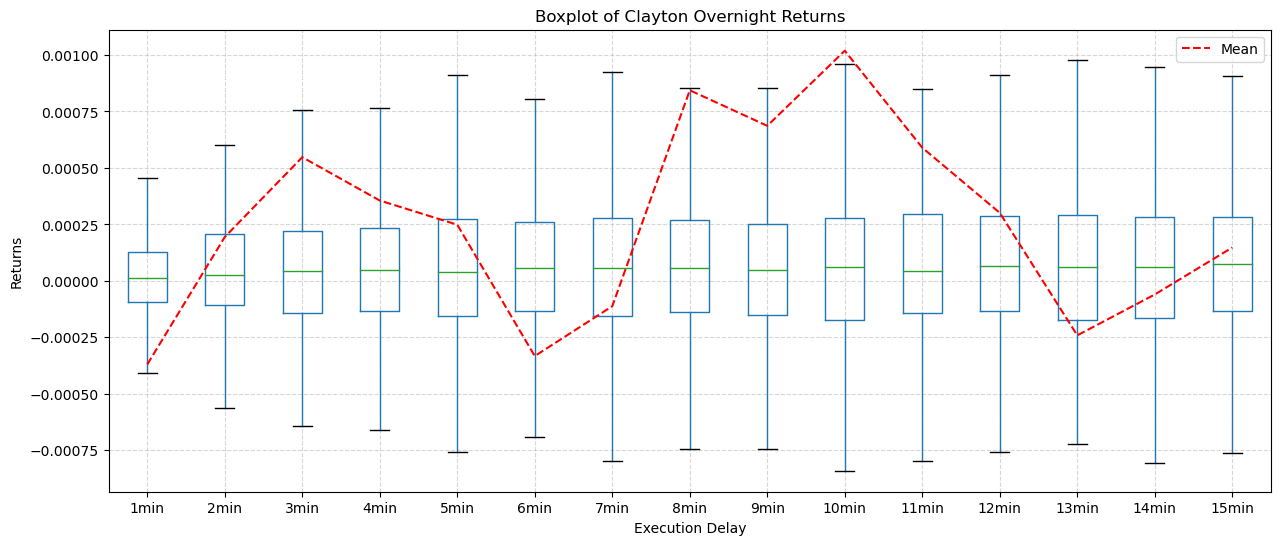

In [55]:
c = 'clayton'
df = pd.read_csv(f'./data/results/delay_{c}_overnight.csv', parse_dates=[0], index_col=0)

fig, ax = plt.subplots(figsize=(15, 6))
df.boxplot(ax=ax, showfliers=False)

x = range(1, df.shape[1]+1)
mean, std = df.mean(), df.std()
ax.plot(x, mean, c='r', linestyle='--', label='Mean')
ax.set_title(f"Boxplot of {c.capitalize()} Overnight Returns")
ax.set_ylabel("Returns")
ax.set_xlabel("Execution Delay")
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
plt.show()

## 6.4 Portfolio Optimization

Our initial hypothesis of the equally weighted portfolio and Ledoit Wolf shrinkage for covariance estimations work as expected. The underlying assets - the pair spreads, turned out to be uncorrelated, thus making the assumption of the identity matrix or the diagonalized matrix of the covariances a good estimate.  

For Gumbel copula, the mean returns across the three years and the Sharpe Ratios are the best for the equally weighted portfolio and the LW (Ledoit Wolf) derived weights. This is primrily because the Empirical or the Marcenko Pastur denoised covariances end up weighing a certain asset higher than the others thus leading to a bigger overall volatility driving down the returns and the Sharpe ratio. 

Furthermore, these two also reduce the VaR quite significantly as well as the CVaR, thus being good portfolio optimization techniques.

In [56]:
for c in copulae:
    print(c.capitalize())
    display(pd.read_csv(f'./data/results/weighted_returns_{c}.csv', index_col=[0,1]).T.iloc[:-7])

Mixed


Year                           2020                                       \
Weighting                     Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.608711  -1.828789  -1.373455      -1.828957   
Annualized Volatility      1.151303   1.926679   2.266219       1.926475   
Annualized Sharpe Ratio    0.528715  -0.949192  -0.606055       -0.94938   
Annualized Sortino Ratio   0.521941  -0.734273  -0.486935       -0.73441   
Skewness                  -1.598973  -5.156893  -4.623642      -5.157716   
Excess Kurtosis           59.864896  49.467341   38.79713      49.484436   
VaR (0.05)                -0.000738  -0.001123  -0.001141      -0.001123   
CVaR (0.05)               -0.100145  -0.257479  -0.305094      -0.257437   

Year                             2021                            \
Weighting                       Equal    Empirical   LedoitWolf   
Annualized Return            9.589233      7.35218     6.844172   
Annualized Volatility        5.243344     4.526052     4.371184   
Annualized Sharpe Ratio      1.828839     1.624413     1.565748   
Annualized Sortino Ratio  2821.634607  1736.503769  1623.121326   
Skewness                    12.374858    10.997614    11.910284   
Excess Kurtosis             168.39369   121.734551    147.77489   
VaR (0.05)                  -0.000318    -0.000572    -0.000483   
CVaR (0.05)                 -0.000568    -0.000855    -0.000788   

Year                                           2022                       \
Weighting                MarcenkoPastur       Equal Empirical LedoitWolf   
Annualized Return               7.32519    3.868619  0.008114   0.011821   
Annualized Volatility          4.509774    3.707088  0.008411   0.007192   
Annualized Sharpe Ratio        1.624292    1.043573   0.96469   1.643673   
Annualized Sortino Ratio    1732.044823  509.991179  1.302622   2.532809   
Skewness                      11.001527   15.551418  -0.06906   1.431825   
Excess Kurtosis                121.8508  241.896637  5.456469  11.087701   
VaR (0.05)                    -0.000572   -0.000486 -0.000836  -0.000558   
CVaR (0.05)                   -0.000851   -0.001249 -0.001191  -0.000888   

Year                                     
Weighting                MarcenkoPastur  
Annualized Return              0.008105  
Annualized Volatility          0.008422  
Annualized Sharpe Ratio        0.962436  
Annualized Sortino Ratio       1.297454  
Skewness                      -0.078942  
Excess Kurtosis                5.540706  
VaR (0.05)                    -0.000837  
CVaR (0.05)                   -0.001192

Gumbel


Year                           2020                                       \
Weighting                     Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return           0.02111   0.020181   0.025845       0.020274   
Annualized Volatility       0.00898   0.013993   0.013406       0.013986   
Annualized Sharpe Ratio    2.350854   1.442191   1.927906       1.449644   
Annualized Sortino Ratio    2.53495   1.855054   2.602003       1.859875   
Skewness                  -1.044208   1.327155   1.839774       1.322318   
Excess Kurtosis           11.182443  17.584208   20.99568      17.594838   
VaR (0.05)                -0.000482  -0.001215    -0.0008      -0.001215   
CVaR (0.05)               -0.001312  -0.002029  -0.001792      -0.002029   

Year                           2021                                      \
Weighting                     Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.004477 -0.001555    0.00141      -0.001502   
Annualized Volatility      0.005201  0.006545   0.005628        0.00654   
Annualized Sharpe Ratio      0.8607 -0.237605   0.250475      -0.229611   
Annualized Sortino Ratio   0.981922 -0.320935   0.278643      -0.310431   
Skewness                  -1.323536 -0.393956  -1.578744      -0.390006   
Excess Kurtosis           15.697902  4.814732  12.051196       4.833624   
VaR (0.05)                -0.000417 -0.000662  -0.000435      -0.000662   
CVaR (0.05)               -0.000791 -0.000966  -0.000907      -0.000964   

Year                            2022                                        
Weighting                      Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           0.336525   0.002672    0.340865       0.002652  
Annualized Volatility       0.351163   0.035054    0.351171       0.035054  
Annualized Sharpe Ratio     0.958316   0.076225    0.970653       0.075657  
Annualized Sortino Ratio    2.732882   0.071751    2.809338       0.071492  
Skewness                   12.745452  -3.746727   12.742195      -3.746796  
Excess Kurtosis           183.684138  95.105578  183.626372       95.10907  
VaR (0.05)                  -0.00047  -0.001151    -0.00088       -0.00115  
CVaR (0.05)                -0.009495  -0.003444   -0.009649      -0.003445

Clayton


Year                          2020                                       \
Weighting                    Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.02044   0.028308   0.030856       0.028504   
Annualized Volatility      0.00925   0.015458   0.014015        0.01546   
Annualized Sharpe Ratio   2.209774   1.831335   2.201605       1.843769   
Annualized Sortino Ratio  2.556511   2.413816   2.963496       2.428955   
Skewness                  -0.00354   1.646902   1.786262       1.648325   
Excess Kurtosis           9.854577  15.638547  18.288543      15.641026   
VaR (0.05)               -0.000517   -0.00108  -0.000842      -0.001079   
CVaR (0.05)              -0.001355  -0.002138  -0.001867      -0.002137   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return         0.003747  0.010019   0.004788       0.009916   
Annualized Volatility     0.004789  0.007048    0.00538       0.007046   
Annualized Sharpe Ratio   0.782429  1.421477   0.889896       1.407391   
Annualized Sortino Ratio    1.0696  1.873125   1.142161       1.856614   
Skewness                 -0.372211 -0.469548  -0.973658      -0.467101   
Excess Kurtosis           3.331281  4.026918   5.944696       4.030974   
VaR (0.05)               -0.000401 -0.000613   -0.00041       -0.00061   
CVaR (0.05)              -0.000731 -0.001017  -0.000821      -0.001015   

Year                            2022                                        
Weighting                      Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           0.350805   0.044265    0.344465       0.044245  
Annualized Volatility       0.361761    0.03947    0.361813       0.039472  
Annualized Sharpe Ratio     0.969715   1.121462    0.952051       1.120913  
Annualized Sortino Ratio     2.86515   1.694903    2.923368       1.694031  
Skewness                   13.115794   4.551175   13.113402       4.551138  
Excess Kurtosis           191.501793  58.876874  191.448402      58.873262  
VaR (0.05)                  -0.00056  -0.000949   -0.000725       -0.00095  
CVaR (0.05)                -0.009394  -0.003384   -0.009549      -0.003384

## 6.5 Transaction Costs and Leverage

We now consider transaction costs and leverage in our backtests.


### 6.5.1 Transaction Costs
Given the high frequency nature of this strategy, 2bps of transaction costs is enough to wipe out virtually all of our returns. At the same time, VaR and CVaR are mostly smaller than annual 5%, which indicates that the methodology is overall limiting the downside risk.

In [57]:
import pandas as pd
copulae = ['gumbel', 'clayton', 'mixed']

for c in copulae:
    print(c.capitalize())
    display(pd.read_csv(f"./data/results/weighted_performance_{c}_DELAY_3_overnight_TRANSACTION_COST.csv", index_col=[0, 1]).T.iloc[:-7])

Gumbel


Year                           2020                                      \
Weighting                     Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return         -0.065856 -0.054929  -0.069202      -0.055091   
Annualized Volatility      0.130557  0.208206   0.175417       0.207719   
Annualized Sharpe Ratio   -0.504423  -0.26382  -0.394499      -0.265217   
Annualized Sortino Ratio  -0.631045 -0.288684  -0.451307      -0.290121   
Skewness                  -0.021624  0.083661   0.053099       0.083385   
Excess Kurtosis           10.335081  5.669999   6.733315       5.729494   
VaR (0.05)                 -0.01009 -0.022937  -0.019219       -0.02293   
CVaR (0.05)               -0.018627 -0.034429  -0.028275       -0.03426   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.076404 -0.113381  -0.078279      -0.113505   
Annualized Volatility     0.093502  0.189633   0.108486       0.189622   
Annualized Sharpe Ratio  -0.817145 -0.597898  -0.721555      -0.598587   
Annualized Sortino Ratio -1.112279 -0.646389  -0.823491      -0.646775   
Skewness                  0.108459 -0.267788  -0.179981      -0.268423   
Excess Kurtosis           1.253655  6.643714   3.887529        6.66098   
VaR (0.05)               -0.010157 -0.023248  -0.011439       -0.02325   
CVaR (0.05)              -0.012611 -0.034318  -0.017898      -0.034326   

Year                            2022                                       
Weighting                      Equal Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           0.282903 -0.029645    0.316313      -0.029625  
Annualized Volatility       0.365522  0.211191    0.390603       0.211231  
Annualized Sharpe Ratio      0.77397  -0.14037    0.809806      -0.140249  
Annualized Sortino Ratio    2.120517 -0.165636    1.732353      -0.165486  
Skewness                   10.786467  0.373007    8.820021        0.37248  
Excess Kurtosis           146.930784  11.19381  112.130566      11.183251  
VaR (0.05)                 -0.013237 -0.023646   -0.020814      -0.023671  
CVaR (0.05)                 -0.02317 -0.030966   -0.033239      -0.030969

Clayton


Year                          2020                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.065015 -0.068623  -0.040758      -0.068366   
Annualized Volatility      0.10583  0.242013   0.132059       0.242039   
Annualized Sharpe Ratio  -0.614335 -0.283553  -0.308632      -0.282457   
Annualized Sortino Ratio -0.772064 -0.309767  -0.369516      -0.308538   
Skewness                  -0.19709 -0.220392  -0.017947      -0.220934   
Excess Kurtosis           1.844169  6.178767   3.897356       6.173681   
VaR (0.05)               -0.010124 -0.023585  -0.014262      -0.023665   
CVaR (0.05)              -0.016132 -0.040233  -0.020025      -0.040242   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.162987 -0.130171  -0.137377      -0.130931   
Annualized Volatility     0.103897  0.180293   0.128218       0.180329   
Annualized Sharpe Ratio  -1.568739 -0.721998  -1.071431      -0.726069   
Annualized Sortino Ratio -2.049059 -0.844299  -1.305404      -0.849116   
Skewness                  0.030287 -0.124944   0.017947      -0.124455   
Excess Kurtosis            2.24961  2.662938   2.696593       2.654722   
VaR (0.05)               -0.011043 -0.024899  -0.014872      -0.024948   
CVaR (0.05)              -0.016017 -0.028893  -0.019875      -0.028886   

Year                           2022                                        
Weighting                     Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return          0.343661   0.063005     0.34056       0.062894  
Annualized Volatility      0.386816     0.2084    0.405775       0.208265  
Annualized Sharpe Ratio    0.888436   0.302328    0.839282       0.301989  
Annualized Sortino Ratio   2.523275   0.343683    1.903553       0.343261  
Skewness                  11.718815   0.346657   10.162657       0.346587  
Excess Kurtosis           165.95869  14.293016  137.325854      14.321584  
VaR (0.05)                -0.012591  -0.016852   -0.014453      -0.016823  
CVaR (0.05)               -0.021401  -0.033462   -0.028751       -0.03344

Mixed


Year                           2020                                       \
Weighting                     Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.380826  -1.905326  -1.569256       -1.90486   
Annualized Volatility      1.192905   1.944358   2.282865        1.94418   
Annualized Sharpe Ratio    0.319242  -0.979925  -0.687406      -0.979775   
Annualized Sortino Ratio   0.339109  -0.785456  -0.571663      -0.785332   
Skewness                  -0.904928  -5.103322  -4.556847      -5.103992   
Excess Kurtosis           58.325763  48.473607  38.018109        48.4879   
VaR (0.05)                -0.015119   -0.02341  -0.020163      -0.023409   
CVaR (0.05)                -0.12424  -0.283108  -0.331073      -0.283122   

Year                            2021                                         \
Weighting                      Equal   Empirical  LedoitWolf MarcenkoPastur   
Annualized Return           9.551286    7.325009    6.836108        7.29841   
Annualized Volatility       5.240667    4.528551    4.372169       4.512272   
Annualized Sharpe Ratio     1.822532    1.617517    1.563551       1.617458   
Annualized Sortino Ratio  149.579025   52.670621   68.681911      52.546384   
Skewness                   12.366563   10.980355   11.902208      10.984194   
Excess Kurtosis           168.221301  121.476553  147.644541     121.591531   
VaR (0.05)                 -0.009974   -0.016774   -0.011378      -0.016765   
CVaR (0.05)                -0.011326   -0.026054   -0.017622      -0.026049   

Year                            2022                                       
Weighting                      Equal  Empirical LedoitWolf MarcenkoPastur  
Annualized Return           3.233573  -0.083497  -0.066488      -0.083589  
Annualized Volatility       3.099948   0.167029   0.120949       0.166942  
Annualized Sharpe Ratio     1.043106  -0.499895  -0.549716      -0.500705  
Annualized Sortino Ratio   42.483261  -0.559409  -0.652458      -0.560262  
Skewness                   15.520124   0.295826   0.078295       0.297137  
Excess Kurtosis           241.244193  10.690003   4.809738      10.755666  
VaR (0.05)                 -0.010513  -0.016123  -0.012203      -0.016056  
CVaR (0.05)                -0.014334  -0.027694  -0.019037      -0.027675

### 6.5.2 Leverage
Below table is the portfolio analysis of 5 times more leveraged trading assumption. We only considered single copulas (gumbel and clayton) as the mixed copula is already showing superior return and Sharpe ratio, whitout additional leverage.

The results of the leverage assumption shows that the return and kurtosis increased, and for the many of the periods, return turned to be positive. Still, considerting VaR is still under 5%, the leverage assumption showed higher return while limiting the downside risk. Also, the sharpe ratio turned to be positive for many periods. However, with regards to the skewness, the additional leverage amplifies it, such that some of the periods and portfolios have highly negative skewness.

In [58]:
for c in copulae[:2]:
    print(c.capitalize())
    display(pd.read_csv(f"./data/results/weighted_performance_{c}_DELAY_3_overnight_LEVERAGE.csv", index_col=[0, 1]).T.iloc[:-8])

Gumbel


Year                           2020                                       \
Weighting                     Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.095549   0.090903   0.119225       0.091371   
Annualized Volatility      0.044898   0.069965   0.067029       0.069928   
Annualized Sharpe Ratio    2.128127   1.299263   1.778715        1.30664   
Annualized Sortino Ratio   2.329983   1.693739   2.425575       1.695033   
Skewness                  -1.044208   1.327155   1.839774       1.322318   
Excess Kurtosis           11.182443  17.584208   20.99568      17.594838   
VaR (0.05)                -0.002448  -0.006113  -0.004041      -0.006113   

Year                           2021                                      \
Weighting                     Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return          0.002383 -0.027775  -0.012952      -0.027508   
Annualized Volatility      0.026006  0.032723   0.028138       0.032699   
Annualized Sharpe Ratio    0.091646 -0.848799  -0.460311      -0.841258   
Annualized Sortino Ratio   0.105832 -1.147458  -0.520836      -1.138276   
Skewness                  -1.323536 -0.393956  -1.578744      -0.390006   
Excess Kurtosis           15.697902  4.814732  12.051196       4.833624   
VaR (0.05)                -0.002164 -0.003388  -0.002257      -0.003389   

Year                            2022                                        
Weighting                      Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           1.632625   -0.03664    1.654327       -0.03674  
Annualized Volatility       1.755815   0.175268    1.755856        0.17527  
Annualized Sharpe Ratio     0.929839  -0.209053    0.942177      -0.209618  
Annualized Sortino Ratio    2.899574  -0.208681    2.905966      -0.209241  
Skewness                   12.745452  -3.746727   12.742195      -3.746796  
Excess Kurtosis           183.684138  95.105578  183.626372       95.10907  
VaR (0.05)                 -0.002549  -0.005955   -0.004596      -0.005947

Clayton


Year                          2020                                       \
Weighting                    Equal  Empirical LedoitWolf MarcenkoPastur   
Annualized Return           0.0922   0.131541    0.14428       0.132522   
Annualized Volatility     0.046249   0.077289   0.070076       0.077299   
Annualized Sharpe Ratio   1.993554    1.70195   2.058902       1.714401   
Annualized Sortino Ratio  2.333046   2.249119   2.787244       2.264449   
Skewness                  -0.00354   1.646902   1.786262       1.648325   
Excess Kurtosis           9.854577  15.638547  18.288543      15.641026   
VaR (0.05)               -0.002623  -0.005438  -0.004251      -0.005437   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.001263  0.030096   0.003938        0.02958   
Annualized Volatility     0.023947  0.035242   0.026899       0.035228   
Annualized Sharpe Ratio  -0.052756  0.853971   0.146381       0.839663   
Annualized Sortino Ratio -0.072291  1.129251   0.188681       1.110516   
Skewness                 -0.372211 -0.469548  -0.973658      -0.467101   
Excess Kurtosis           3.331281  4.026918   5.944696       4.030974   
VaR (0.05)               -0.002085 -0.003145  -0.002131       -0.00313   

Year                            2022                                        
Weighting                      Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           1.704026   0.171323    1.672324       0.171225  
Annualized Volatility       1.808805   0.197352    1.809066       0.197361  
Annualized Sharpe Ratio     0.942073   0.868108    0.924413        0.86757  
Annualized Sortino Ratio    2.954959   1.358249    2.976091       1.357384  
Skewness                   13.115794   4.551175   13.113402       4.551138  
Excess Kurtosis           191.501793  58.876874  191.448402      58.873262  
VaR (0.05)                 -0.002999  -0.004941   -0.003822      -0.004947

### 6.5.3 Transaction Costs and Leverage

In [59]:
for c in copulae[:2]:
    print(c.capitalize())
    display(pd.read_csv(f"./data/results/weighted_performance_{c}_DELAY_3_overnight_LEVERAGE_TRANSACTION_COST.csv", index_col=[0, 1]).T.iloc[:-8])

Gumbel


Year                           2020                                      \
Weighting                     Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return         -0.339279 -0.284645  -0.356009      -0.285453   
Annualized Volatility      0.652784  1.041032   0.877084       1.038596   
Annualized Sharpe Ratio   -0.519742 -0.273426  -0.405901      -0.274845   
Annualized Sortino Ratio  -0.652412 -0.303332  -0.466555      -0.303978   
Skewness                  -0.021624  0.083661   0.053099       0.083385   
Excess Kurtosis           10.335081  5.669999   6.733315       5.729494   
VaR (0.05)                 -0.05049 -0.114723  -0.096133      -0.114691   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.402022 -0.586904  -0.411394      -0.587525   
Annualized Volatility     0.467509  0.948163   0.542431       0.948108   
Annualized Sharpe Ratio  -0.859924 -0.618991  -0.758426      -0.619681   
Annualized Sortino Ratio  -1.17135 -0.675119  -0.874893      -0.675507   
Skewness                  0.108459 -0.267788  -0.179981      -0.268423   
Excess Kurtosis           1.253655  6.643714   3.887529        6.66098   
VaR (0.05)               -0.050865 -0.116321  -0.057274       -0.11633   

Year                            2022                                       
Weighting                      Equal Empirical  LedoitWolf MarcenkoPastur  
Annualized Return           1.364513 -0.198225    1.531563      -0.198125  
Annualized Volatility       1.827608  1.055955    1.953016       1.056156  
Annualized Sharpe Ratio     0.746612 -0.187721    0.784204       -0.18759  
Annualized Sortino Ratio    2.092402  -0.22795    1.702685      -0.227782  
Skewness                   10.786467  0.373007    8.820021        0.37248  
Excess Kurtosis           146.930784  11.19381  112.130566      11.183251  
VaR (0.05)                 -0.066385 -0.118429   -0.104266      -0.118554

Clayton


Year                          2020                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.335074 -0.353117  -0.213788      -0.351828   
Annualized Volatility     0.529149  1.210064   0.660293       1.210196   
Annualized Sharpe Ratio  -0.633233 -0.291817  -0.323777       -0.29072   
Annualized Sortino Ratio  -0.79679   -0.3197  -0.388312      -0.318465   
Skewness                  -0.19709 -0.220392  -0.017947      -0.220934   
Excess Kurtosis           1.844169  6.178767   3.897356       6.173681   
VaR (0.05)                -0.05066 -0.117966   -0.07135      -0.118365   

Year                          2021                                      \
Weighting                    Equal Empirical LedoitWolf MarcenkoPastur   
Annualized Return        -0.834937 -0.670856  -0.706884      -0.674656   
Annualized Volatility     0.519486  0.901465    0.64109       0.901644   
Annualized Sharpe Ratio  -1.607238 -0.744184  -1.102628      -0.748251   
Annualized Sortino Ratio -2.102495 -0.876085  -1.345583      -0.878961   
Skewness                  0.030287 -0.124944   0.017947      -0.124455   
Excess Kurtosis            2.24961  2.662938   2.696593       2.654722   
VaR (0.05)               -0.055296 -0.124575   -0.07444      -0.124819   

Year                           2022                                        
Weighting                     Equal  Empirical  LedoitWolf MarcenkoPastur  
Annualized Return          1.668306   0.265026    1.652799       0.264469  
Annualized Volatility      1.934079   1.042001    2.028875       1.041325  
Annualized Sharpe Ratio    0.862584   0.254343    0.814638       0.253973  
Annualized Sortino Ratio   2.473727   0.297663    1.887826       0.297201  
Skewness                  11.718815   0.346657   10.162657       0.346587  
Excess Kurtosis           165.95869  14.293016  137.325854      14.321584  
VaR (0.05)                -0.063153  -0.084459   -0.072461      -0.084313